<h1 style="text-align: center;">
☀️🌨️ Previsões Climáticas - Séries Temporais 🌧️🌤️
</h1>

![GIF](https://media3.giphy.com/media/1NZVjc68MgkT4X8BQi/source.gif)

# Sumário

1. [Introdução](#1.-Introdução)
2. [Importação das Bibliotecas](#2.-Importação-das-Bibliotecas)
3. [Importação dos Dados](#3.-Importação-dos-Dados)
4. [Análise Exploratória dos Dados (EDA)](#4.-Análise-Exploratória-dos-Dados-(EDA))  
   4.1 [Conjunto de dados](#4.1-Conjunto-de-dados)  
   4.2 [Estatísticas](#4.2-Estatísticas)  
   4.3 [Gráficos das séries temporais](#4.3-Gráficos-das-séries-temporais)  
   4.4 [Matriz de Correlação](#4.4-Matriz-de-Correlação)  
   4.5 [Gráfico de Barras de Correlação](#4.5-Gráfico-de-Barras-de-Correlação)  
   4.6 [Gráficos de Box Plots](#4.6-Gráficos-de-Box-Plots)  
   4.7 [Gráficos de Dispersão](#4.7-Gráficos-de-Dispersão)  
   4.8 [Histogramas](#4.8-Histogramas)  
   4.9 [Exemplo de Média Móvel Exponencialmente Ponderada em 2013](#4.9-Exemplo-de-Média-Móvel-Exponencialmente-Ponderada-em-2013)  
5. [Seleção de Features](#5.-Seleção-de-Features)  
6. [Análise da Target (temperatura_media)](#6.-Análise-da-Target-(temperatura_media))  
    6.1 [Teste de Estacionariedade](#6.1-Teste-de-Estacionariedade)  
    6.2 [Tendência e Sazonalidade](#6.2-Tendência-e-Sazonalidade)  
    6.3 [Função de Autocorrelação (ACF)](#6.3-Função-de-Autocorrelação-(ACF))  
    6.4 [Função de Autocorrelação Parcial (PACF)](#6.4-Função-de-Autocorrelação-Parcial-(PACF))  
7. [Preparação dos Dados](#7.-Preparação-dos-Dados)  
8. [Treinamento dos Modelos](#8.-Treinamento-dos-Modelos)  
    8.1 [ARIMA-SARIMA-SARIMAX](#8.1-ARIMA-SARIMA-SARIMAX)  
    8.2 [Auto ARIMA](#8.2-Auto-ARIMA)  
    8.3 [Prophet](#8.3-Prophet)  
9. [Teste e Projeções dos Modelos](#9.-Teste-e-Projeções-dos-Modelos)   
    9.1 [SARIMA](#9.1-SARIMA)  
    9.2 [SARIMAX](#9.2-SARIMAX)  
    9.3 [Prophet1](#9.3-Prophet1)  
    9.4 [Prophet2](#9.4-Prophet2)  
10. [Conclusão](#10.-Conclusão)  

# 1. Introdução

## Sobre os dados

Este arquivo contém dados meteorológicos coletados na cidade de Delhi <b> (hemisfério norte!) </b> no período de 4 meses (2017). Pode ser usado para fins de previsão. Este é um conjunto de dados puramente acadêmico e foi desenvolvido como parte do curso de Análise de Dados de 2019.

### Colunas

- **meantemp** ➔ Temperatura média calculada a partir de múltiplos intervalos de 3 horas em um dia.
- **humidity** ➔ Valor da umidade para o dia (unidades são gramas de vapor d'água por metro cúbico de volume de ar).
- **wind_speed** ➔ Velocidade do vento medida em km/h.
- **meanpressure** ➔ Leitura da pressão atmosférica (medida em atm).

# 2. Importação das Bibliotecas

Importando as bibliotecas e recursos necessários.

In [1]:
# Dados
import pandas as pd

# Matemática
import numpy as np

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns

# Gráficos de autocorrelação
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Gráfico de resíduos
from statsmodels.graphics.gofplots import qqplot

# Testes estatísticos
from statsmodels.tsa.stattools import adfuller, kpss

# Teste de tendência e sazonalidade
from statsmodels.tsa.seasonal import STL

# Métricas de erro
from sklearn.metrics import mean_squared_error, r2_score

# Modelo SARIMAX
import pmdarima as pm
from pmdarima.arima import ARIMA

# Modelo Prophet
from prophet import Prophet

# Exportação do modelo
from joblib import dump, load

# 3. Importação dos Dados

Importando os arquivos com os dados de treino e teste.

In [2]:
df = pd.read_csv(r'DailyDelhiClimateTrain.csv', 
                 parse_dates=['date'], # Transformando a coluna para datetime
                 index_col=['date'])

df_teste = pd.read_csv(r'DailyDelhiClimateTest.csv', 
                       parse_dates=['date'],
                       index_col=['date'])

Renomeando as colunas:

In [3]:
df.index.name = 'data'
df_teste.index.name = 'data'

df.rename(mapper={'meantemp': 'temperatura_media', 
'humidity': 'humidade', 
'wind_speed': 'velocidade_do_vento',
'meanpressure': 'pressao_media'}, axis = 1, inplace = True)

df_teste.rename(mapper={'meantemp': 'temperatura_media', 
'humidity': 'humidade', 
'wind_speed': 'velocidade_do_vento',
'meanpressure': 'pressao_media'}, axis = 1, inplace = True)

Criando novas variáveis para o EDA.

In [4]:
df["ano"] = df.index.year 
df["mes"] = df.index.month 
df_teste["ano"] = df_teste.index.year
df_teste["mes"] = df_teste.index.month 

# Função para categorizar as estações do ano no hemisfério norte
def obter_estacao(dia):
    ano = dia.year
    if pd.Timestamp(ano, 12, 21) <= dia or dia < pd.Timestamp(ano, 3, 21):
        return 1  # Inverno (21 de dezembro a 20 de março)
    elif pd.Timestamp(ano, 3, 21) <= dia < pd.Timestamp(ano, 6, 21):
        return 3  # Primavera (21 de março a 20 de junho)
    elif pd.Timestamp(ano, 6, 21) <= dia < pd.Timestamp(ano, 9, 23):
        return 4  # Verão (21 de junho a 22 de setembro)
    elif pd.Timestamp(ano, 9, 23) <= dia < pd.Timestamp(ano, 12, 21):
        return 2  # Outono (23 de setembro a 20 de dezembro)

# Aplicando a função para criar a nova coluna de estação
df["estacao"] = df.index.map(obter_estacao)
df_teste["estacao"] = df_teste.index.map(obter_estacao)

# 4. Análise Exploratória dos Dados (EDA)

Explorando, visualizando e aprofundando o entendimento sobre os dados.

## 4.1 Conjunto de dados

In [5]:
df.head()

,temperatura_media,humidade,velocidade_do_vento,pressao_media,ano,mes,estacao
data,,,,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667,2013,1,1
2013-01-02,7.400000,92.000000,2.980000,1017.800000,2013,1,1
2013-01-03,7.166667,87.000000,4.633333,1018.666667,2013,1,1
2013-01-04,8.666667,71.333333,1.233333,1017.166667,2013,1,1
2013-01-05,6.000000,86.833333,3.700000,1016.500000,2013,1,1


In [6]:
df.tail()

,temperatura_media,humidade,velocidade_do_vento,pressao_media,ano,mes,estacao
data,,,,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217,2016,12,1
2016-12-29,15.238095,87.857143,6.000000,1016.904762,2016,12,1
2016-12-30,14.095238,89.666667,6.266667,1017.904762,2016,12,1
2016-12-31,15.052632,87.000000,7.325000,1016.100000,2016,12,1
2017-01-01,10.000000,100.000000,0.000000,1016.000000,2017,1,1


In [7]:
df_teste.head()

,temperatura_media,humidade,velocidade_do_vento,pressao_media,ano,mes,estacao
data,,,,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000,2017,1,1
2017-01-02,18.500000,77.222222,2.894444,1018.277778,2017,1,1
2017-01-03,17.111111,81.888889,4.016667,1018.333333,2017,1,1
2017-01-04,18.700000,70.050000,4.545000,1015.700000,2017,1,1
2017-01-05,18.388889,74.944444,3.300000,1014.333333,2017,1,1


In [8]:
df_teste.tail()

,temperatura_media,humidade,velocidade_do_vento,pressao_media,ano,mes,estacao
data,,,,,,,
2017-04-20,34.500,27.500000,5.562500,998.625000,2017,4,3
2017-04-21,34.250,39.375000,6.962500,999.875000,2017,4,3
2017-04-22,32.900,40.900000,8.890000,1001.600000,2017,4,3
2017-04-23,32.875,27.500000,9.962500,1002.125000,2017,4,3
2017-04-24,32.000,27.142857,12.157143,1004.142857,2017,4,3


📝 Dados de treino começam em 01 de janeiro de 2013 e terminam em 01 de janeiro de 2017.  
📝 Dados de teste começam em 01 de janeiro de 2017 e terminam em 04 de abril de 2017.  
📝 Curiosamente 01 de janeiro de 2017 está em ambos datasets e possui valores diferentes de temperatura média, humidade, velocidade do vento e pressão média. Por isso irei remover 2017-01-01 dos dados de treino!

In [9]:
# Removendo 2017-01-01 dos dados de treino
df = df.iloc[:-1]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1461 entries, 2013-01-01 to 2016-12-31
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperatura_media    1461 non-null   float64
 1   humidade             1461 non-null   float64
 2   velocidade_do_vento  1461 non-null   float64
 3   pressao_media        1461 non-null   float64
 4   ano                  1461 non-null   int64  
 5   mes                  1461 non-null   int64  
 6   estacao              1461 non-null   int64  
dtypes: float64(4), int64(3)
memory usage: 91.3 KB


In [11]:
df.index

DatetimeIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
               '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
               '2013-01-09', '2013-01-10',
               ...
               '2016-12-22', '2016-12-23', '2016-12-24', '2016-12-25',
               '2016-12-26', '2016-12-27', '2016-12-28', '2016-12-29',
               '2016-12-30', '2016-12-31'],
              dtype='datetime64[ns]', name='data', length=1461, freq=None)

In [12]:
df_teste.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 114 entries, 2017-01-01 to 2017-04-24
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   temperatura_media    114 non-null    float64
 1   humidade             114 non-null    float64
 2   velocidade_do_vento  114 non-null    float64
 3   pressao_media        114 non-null    float64
 4   ano                  114 non-null    int64  
 5   mes                  114 non-null    int64  
 6   estacao              114 non-null    int64  
dtypes: float64(4), int64(3)
memory usage: 7.1 KB


In [13]:
df_teste.index

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2017-04-15', '2017-04-16', '2017-04-17', '2017-04-18',
               '2017-04-19', '2017-04-20', '2017-04-21', '2017-04-22',
               '2017-04-23', '2017-04-24'],
              dtype='datetime64[ns]', name='data', length=114, freq=None)

📝 Tamanho dos dados de treino (1462,5)  
📝 Tamanho dos dados de teste (114,5)  
📝 Nenhum dos conjuntos de dados possui valores vazios  
📝 As datas no índice estão no formato 'datetime64[ns]' as demais varíaveis de entrada estão no formato 'float64' e as variáveis criadas estão no formato 'int64'.

## 4.2 Estatísticas

In [14]:
df.describe().T.style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
temperatura_media,1461.000000,25.506127,7.339416,6.000000,18.857143,27.714286,31.312500,38.714286
humidade,1461.000000,60.744851,16.743928,13.428571,50.375000,62.625000,72.125000,98.000000
velocidade_do_vento,1461.000000,6.806865,4.559688,0.000000,3.475000,6.250000,9.250000,42.220000
pressao_media,1461.000000,1011.101197,180.293335,-3.041667,1001.571429,1008.555556,1014.937500,7679.333333
ano,1461.000000,2014.501027,1.118723,2013.000000,2014.000000,2015.000000,2016.000000,2016.000000
mes,1461.000000,6.522930,3.449884,1.000000,4.000000,7.000000,10.000000,12.000000
estacao,1461.000000,2.519507,1.122221,1.000000,2.000000,3.000000,4.000000,4.000000


In [15]:
df_teste.describe().T.style.background_gradient(cmap = 'Blues')

,count,mean,std,min,25%,50%,75%,max
temperatura_media,114.000000,21.713079,6.360072,11.000000,16.437198,19.875000,27.705357,34.500000
humidade,114.000000,56.258362,19.068083,17.750000,39.625000,57.750000,71.902778,95.833333
velocidade_do_vento,114.000000,8.143924,3.588049,1.387500,5.563542,8.069444,10.068750,19.314286
pressao_media,114.000000,1004.035090,89.474692,59.000000,1007.437500,1012.739316,1016.739583,1022.809524
ano,114.000000,2017.000000,0.000000,2017.000000,2017.000000,2017.000000,2017.000000,2017.000000
mes,114.000000,2.421053,1.104254,1.000000,1.000000,2.000000,3.000000,4.000000
estacao,114.000000,1.614035,0.926586,1.000000,1.000000,1.000000,3.000000,3.000000


## 4.3 Gráficos das séries temporais

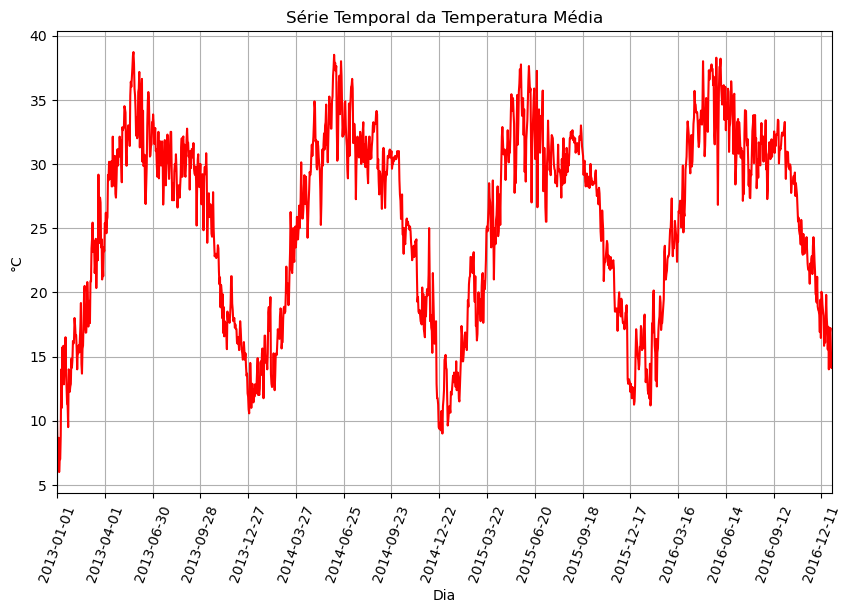

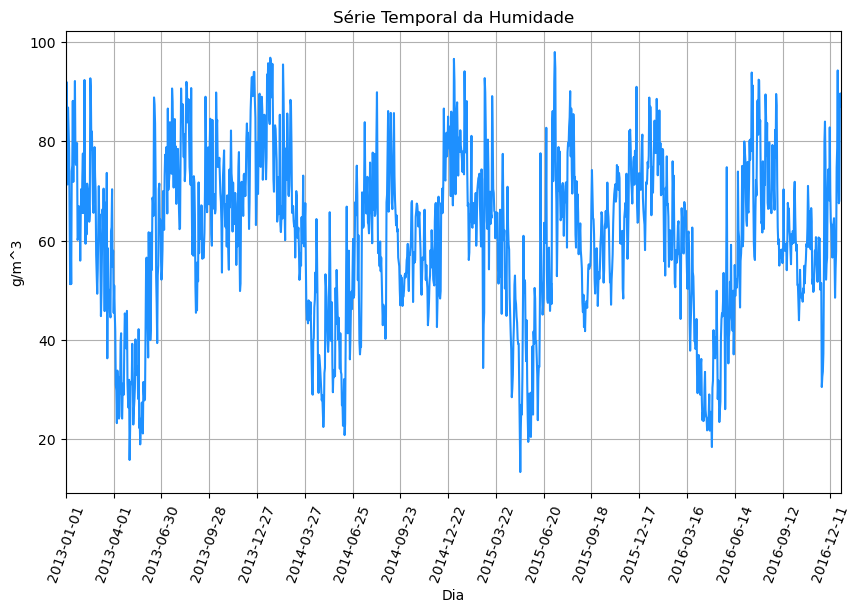

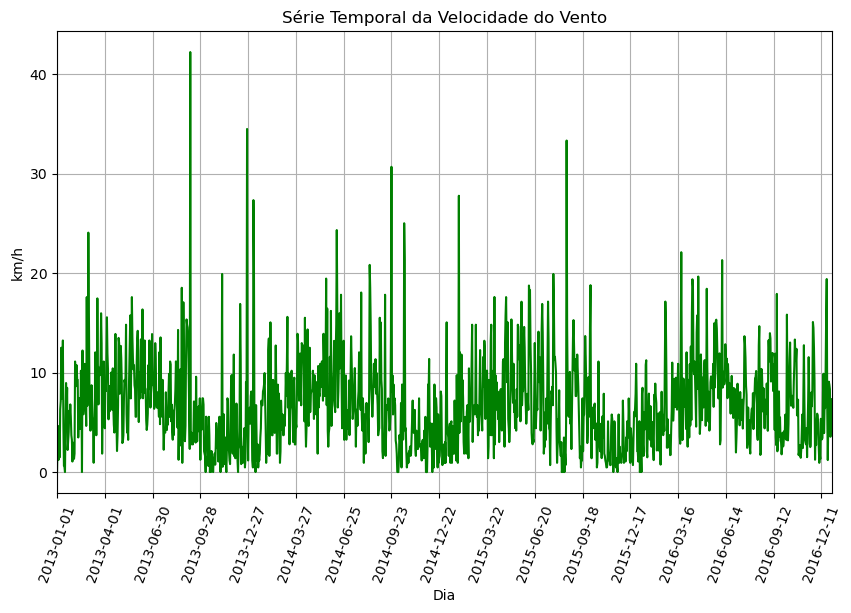

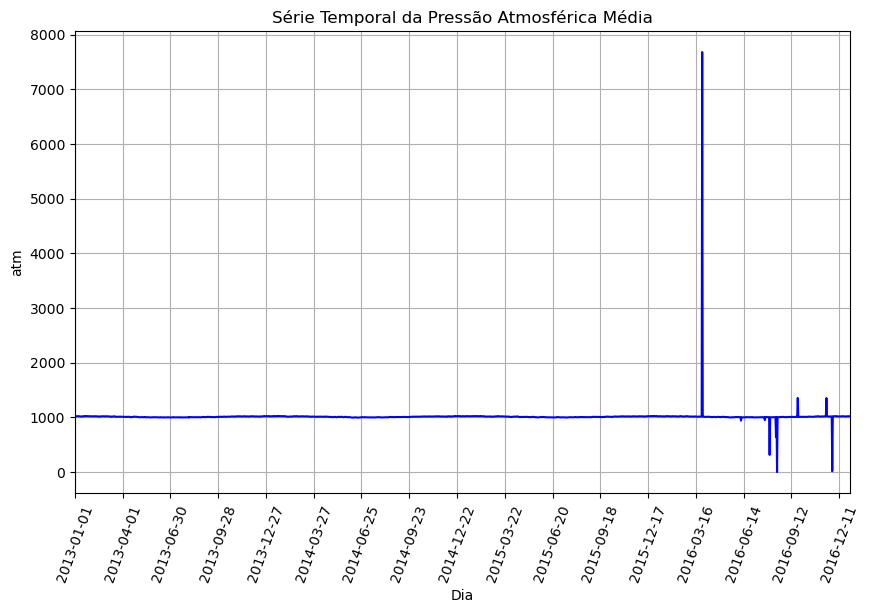

In [16]:
# Definindo as datas do eixo X a cada 90 dias
ticks = []
for i in range(len(df.index)):
    if i%90 == 0:
        ticks.append(df.index[i])

# Grafico da temperatura
plt.figure(figsize=(10, 6))
plt.plot(df['temperatura_media'], color='red')
plt.title('Série Temporal da Temperatura Média')
plt.xlabel('Dia')
plt.ylabel('°C')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

# Grafico da humidade
plt.figure(figsize=(10, 6))
plt.plot(df['humidade'], color = 'dodgerblue')
plt.title('Série Temporal da Humidade')
plt.xlabel('Dia')
plt.ylabel('g/m^3')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

# Grafico da velocidade do vento
plt.figure(figsize=(10, 6))
plt.plot(df['velocidade_do_vento'], color='green')
plt.title('Série Temporal da Velocidade do Vento')
plt.xlabel('Dia')
plt.ylabel('km/h')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

# Grafico da pressão
plt.figure(figsize=(10, 6))
plt.plot(df['pressao_media'], color='blue')
plt.title('Série Temporal da Pressão Atmosférica Média')
plt.xlabel('Dia')
plt.ylabel('atm')
plt.xticks(ticks = ticks,rotation='70')
plt.xlim(df.index.min(),df.index.max())
plt.grid(True)
plt.show()

## 4.4 Matriz de Correlação 

Matriz de correlação linear entre as variáveis.

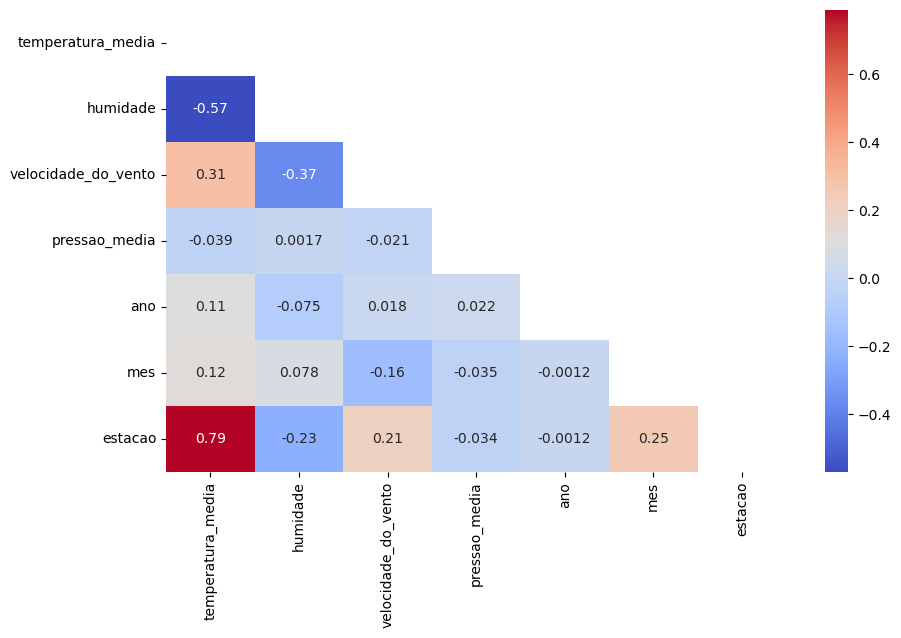

In [17]:
# Máscara para a metade superior
mask = np.triu(np.ones_like(df.corr(), dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(),mask=mask, cmap='coolwarm', annot=True, square=False)
plt.show()

## 4.5 Gráfico de Barras de Correlação 

Mostra a correlação linear entre as variáveis e a temperatura média.

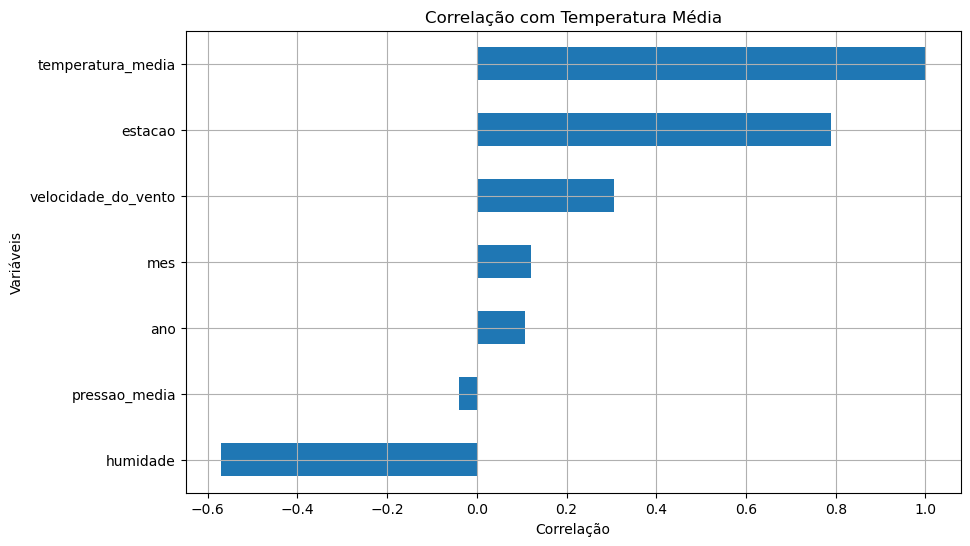

In [18]:
plt.figure(figsize=(10, 6))
df.corr().temperatura_media.sort_values().plot(kind='barh')
plt.title('Correlação com Temperatura Média')
plt.xlabel('Correlação')
plt.ylabel('Variáveis')
plt.grid(True)
plt.show()

## 4.6 Gráficos de Box Plots

#### Humidade

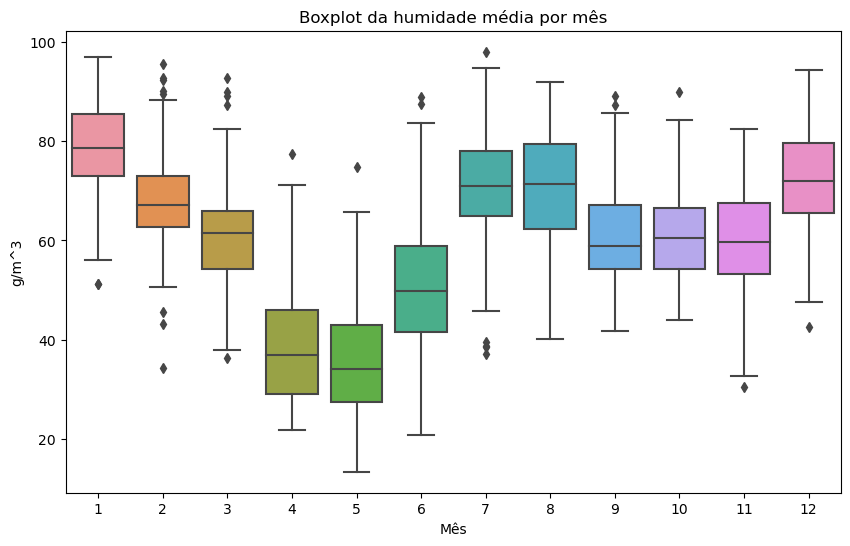

In [19]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='humidade', x='mes', data=df)
plt.title(f'Boxplot da humidade média por mês')
plt.xlabel('Mês')
plt.ylabel('g/m^3')
plt.show()

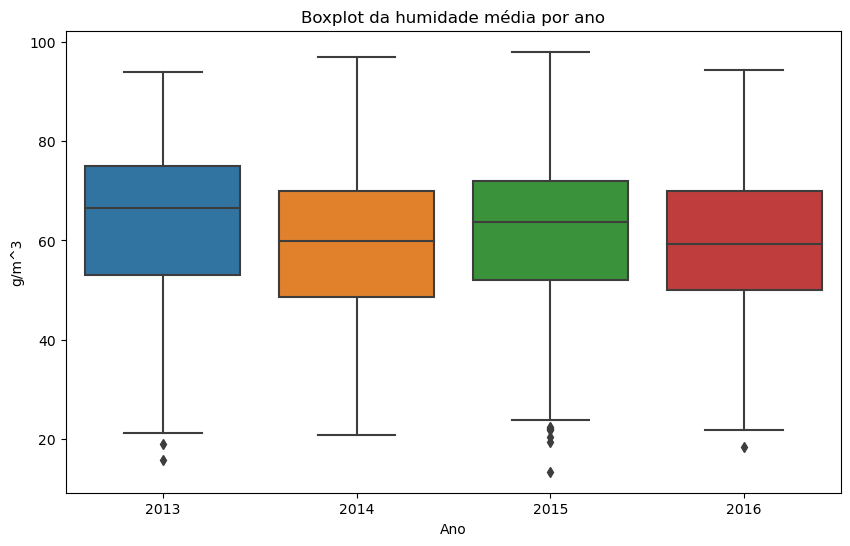

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='humidade', x='ano', data=df)
plt.title(f'Boxplot da humidade média por ano')
plt.xlabel('Ano')
plt.ylabel('g/m^3')
plt.show()

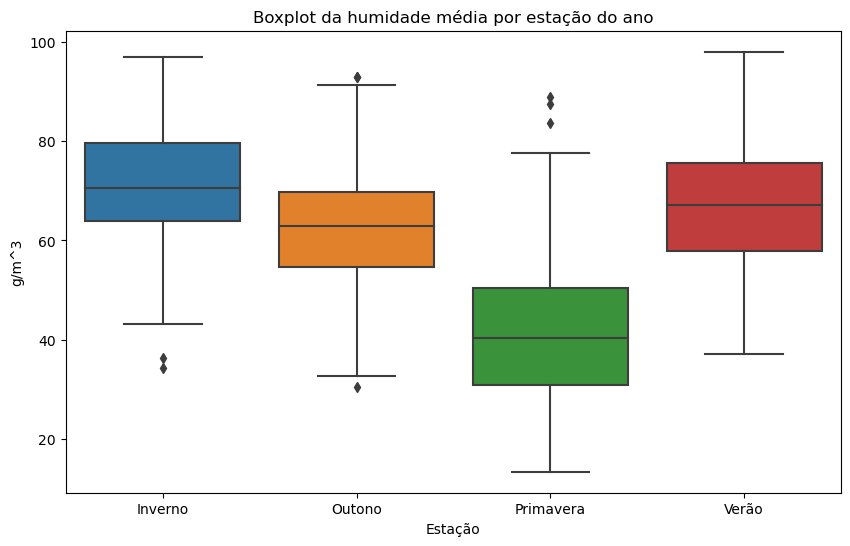

In [21]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='humidade', x='estacao', data=df)
plt.title(f'Boxplot da humidade média por estação do ano')
plt.xlabel('Estação')
plt.ylabel('g/m^3')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Inverno', 'Outono', 'Primavera', 'Verão'])
plt.show()

#### Velocidade do vento

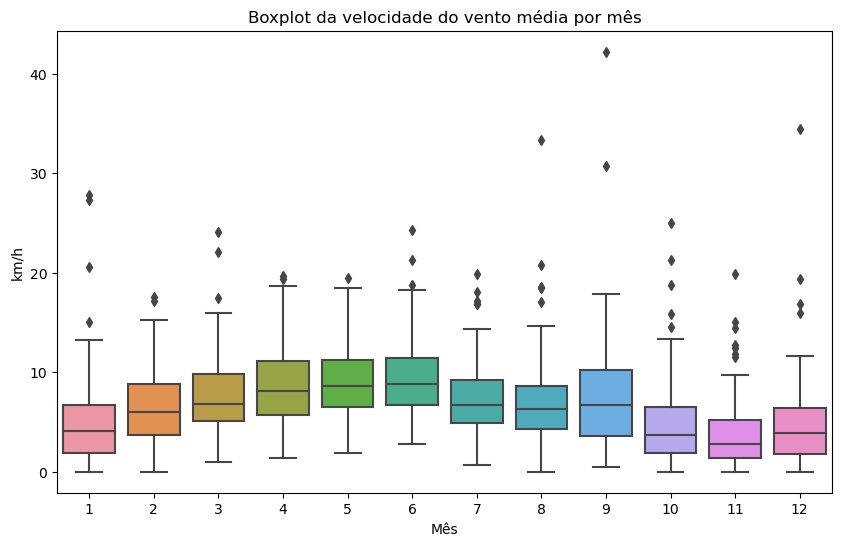

In [22]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='velocidade_do_vento', x='mes', data=df)
plt.title(f'Boxplot da velocidade do vento média por mês')
plt.xlabel('Mês')
plt.ylabel('km/h')
plt.show()

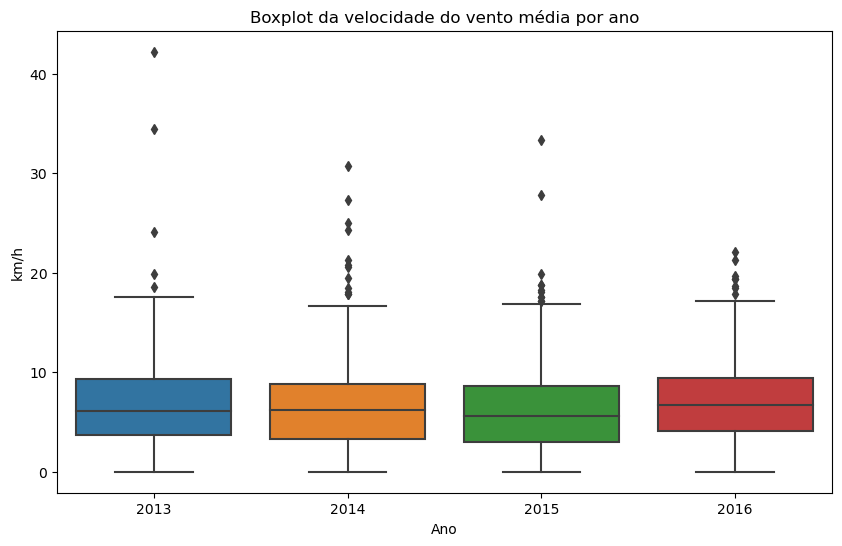

In [23]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='velocidade_do_vento', x='ano', data=df)
plt.title(f'Boxplot da velocidade do vento média por ano')
plt.xlabel('Ano')
plt.ylabel('km/h')
plt.show()

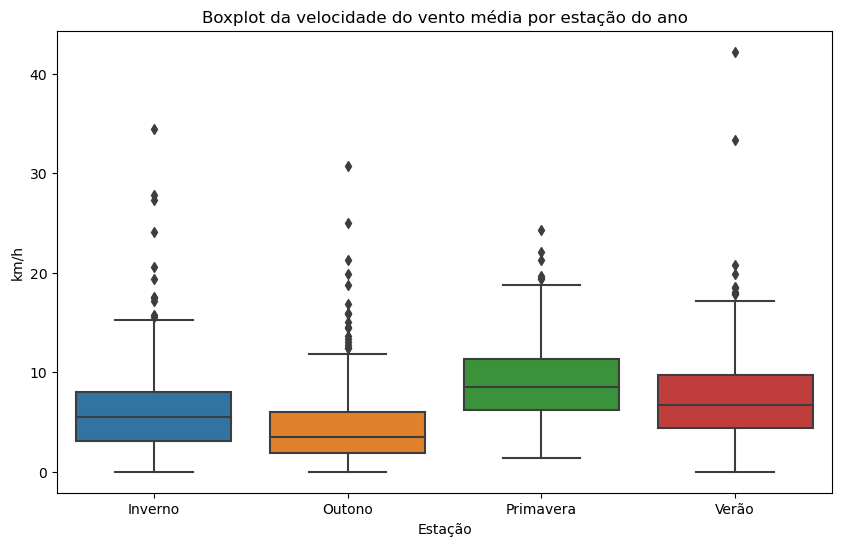

In [24]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='velocidade_do_vento', x='estacao', data=df)
plt.title(f'Boxplot da velocidade do vento média por estação do ano')
plt.xlabel('Estação')
plt.ylabel('km/h')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Inverno', 'Outono', 'Primavera', 'Verão'])
plt.show()

#### Pressão atmosférica

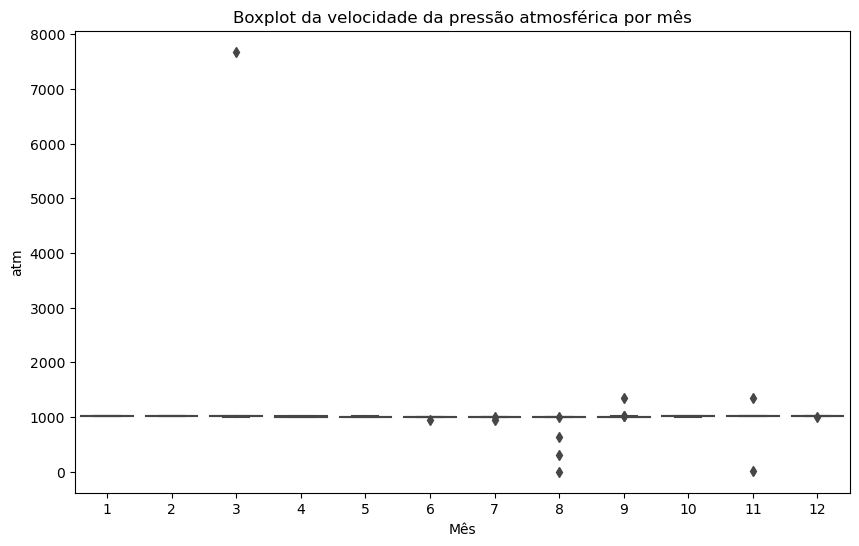

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='pressao_media', x='mes', data=df)
plt.title(f'Boxplot da velocidade da pressão atmosférica por mês')
plt.xlabel('Mês')
plt.ylabel('atm')
plt.show()

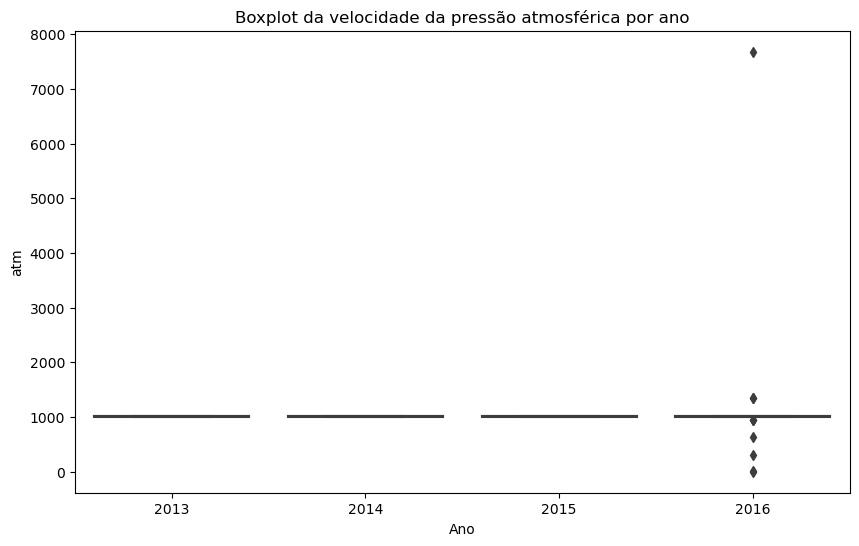

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='pressao_media', x='ano', data=df)
plt.title(f'Boxplot da velocidade da pressão atmosférica por ano')
plt.xlabel('Ano')
plt.ylabel('atm')
plt.show()

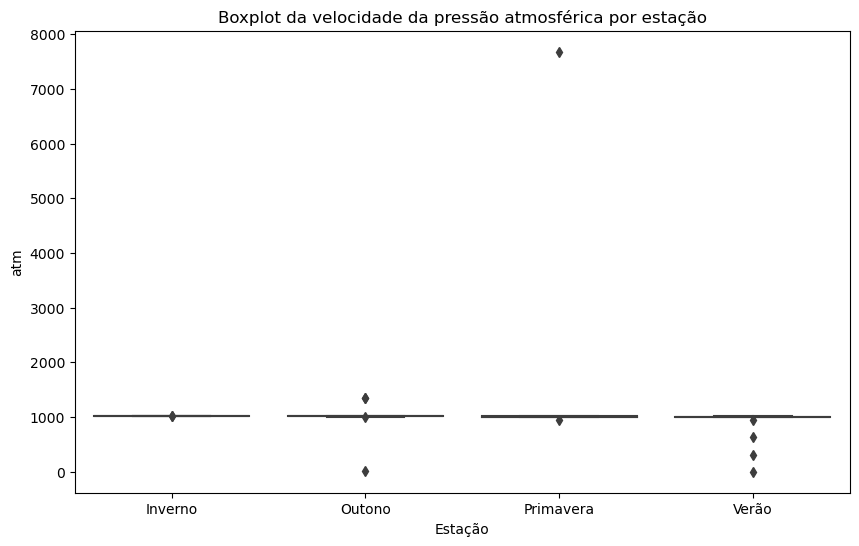

In [27]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='pressao_media', x='estacao', data=df)
plt.title(f'Boxplot da velocidade da pressão atmosférica por estação')
plt.xlabel('Estação')
plt.ylabel('atm')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Inverno', 'Outono', 'Primavera', 'Verão'])
plt.show()

#### Temperatura

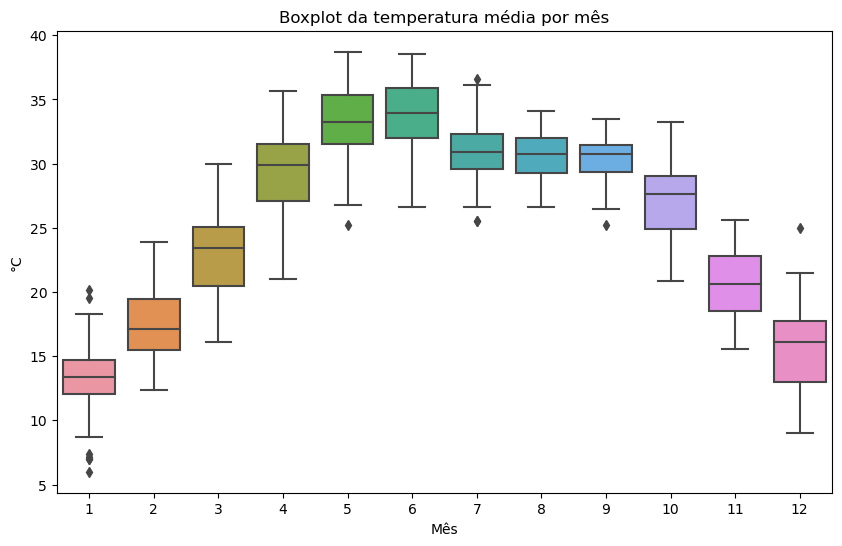

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='temperatura_media', x='mes', data=df)
plt.title(f'Boxplot da temperatura média por mês')
plt.xlabel('Mês')
plt.ylabel('°C')
plt.show()

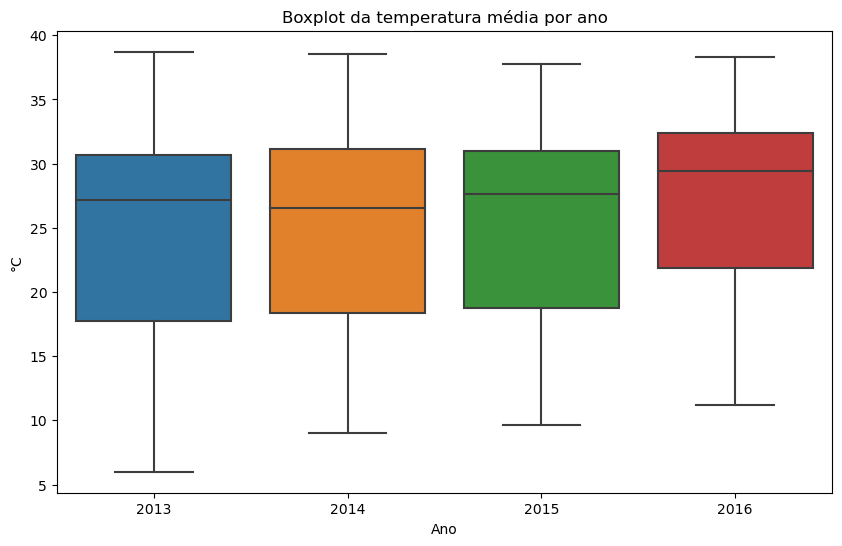

In [29]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='temperatura_media', x='ano', data=df)
plt.title(f'Boxplot da temperatura média por ano')
plt.xlabel('Ano')
plt.ylabel('°C')
plt.show()

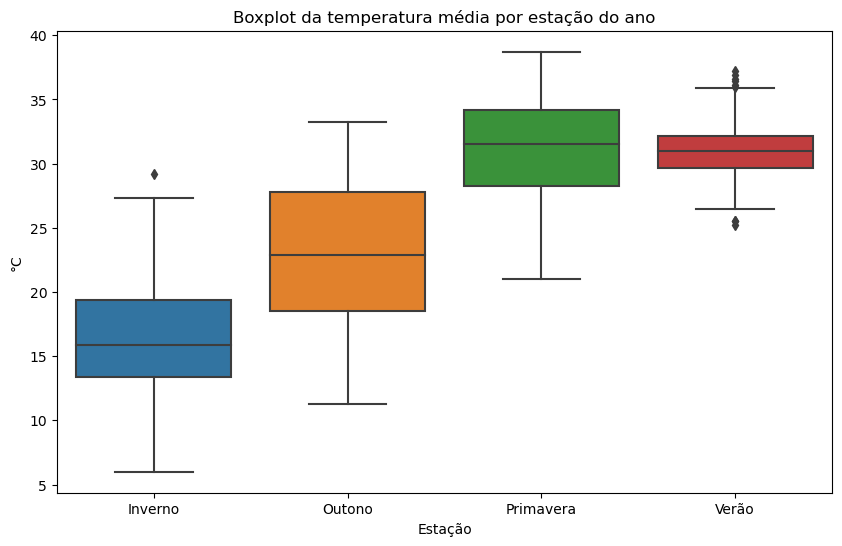

In [30]:
plt.figure(figsize=(10, 6))
sns.boxplot(y='temperatura_media', x='estacao', data=df)
plt.title(f'Boxplot da temperatura média por estação do ano')
plt.xlabel('Estação')
plt.ylabel('°C')
plt.xticks(ticks=[0, 1, 2, 3], labels=['Inverno', 'Outono', 'Primavera', 'Verão'])
plt.show()

## 4.7 Gráficos de Dispersão

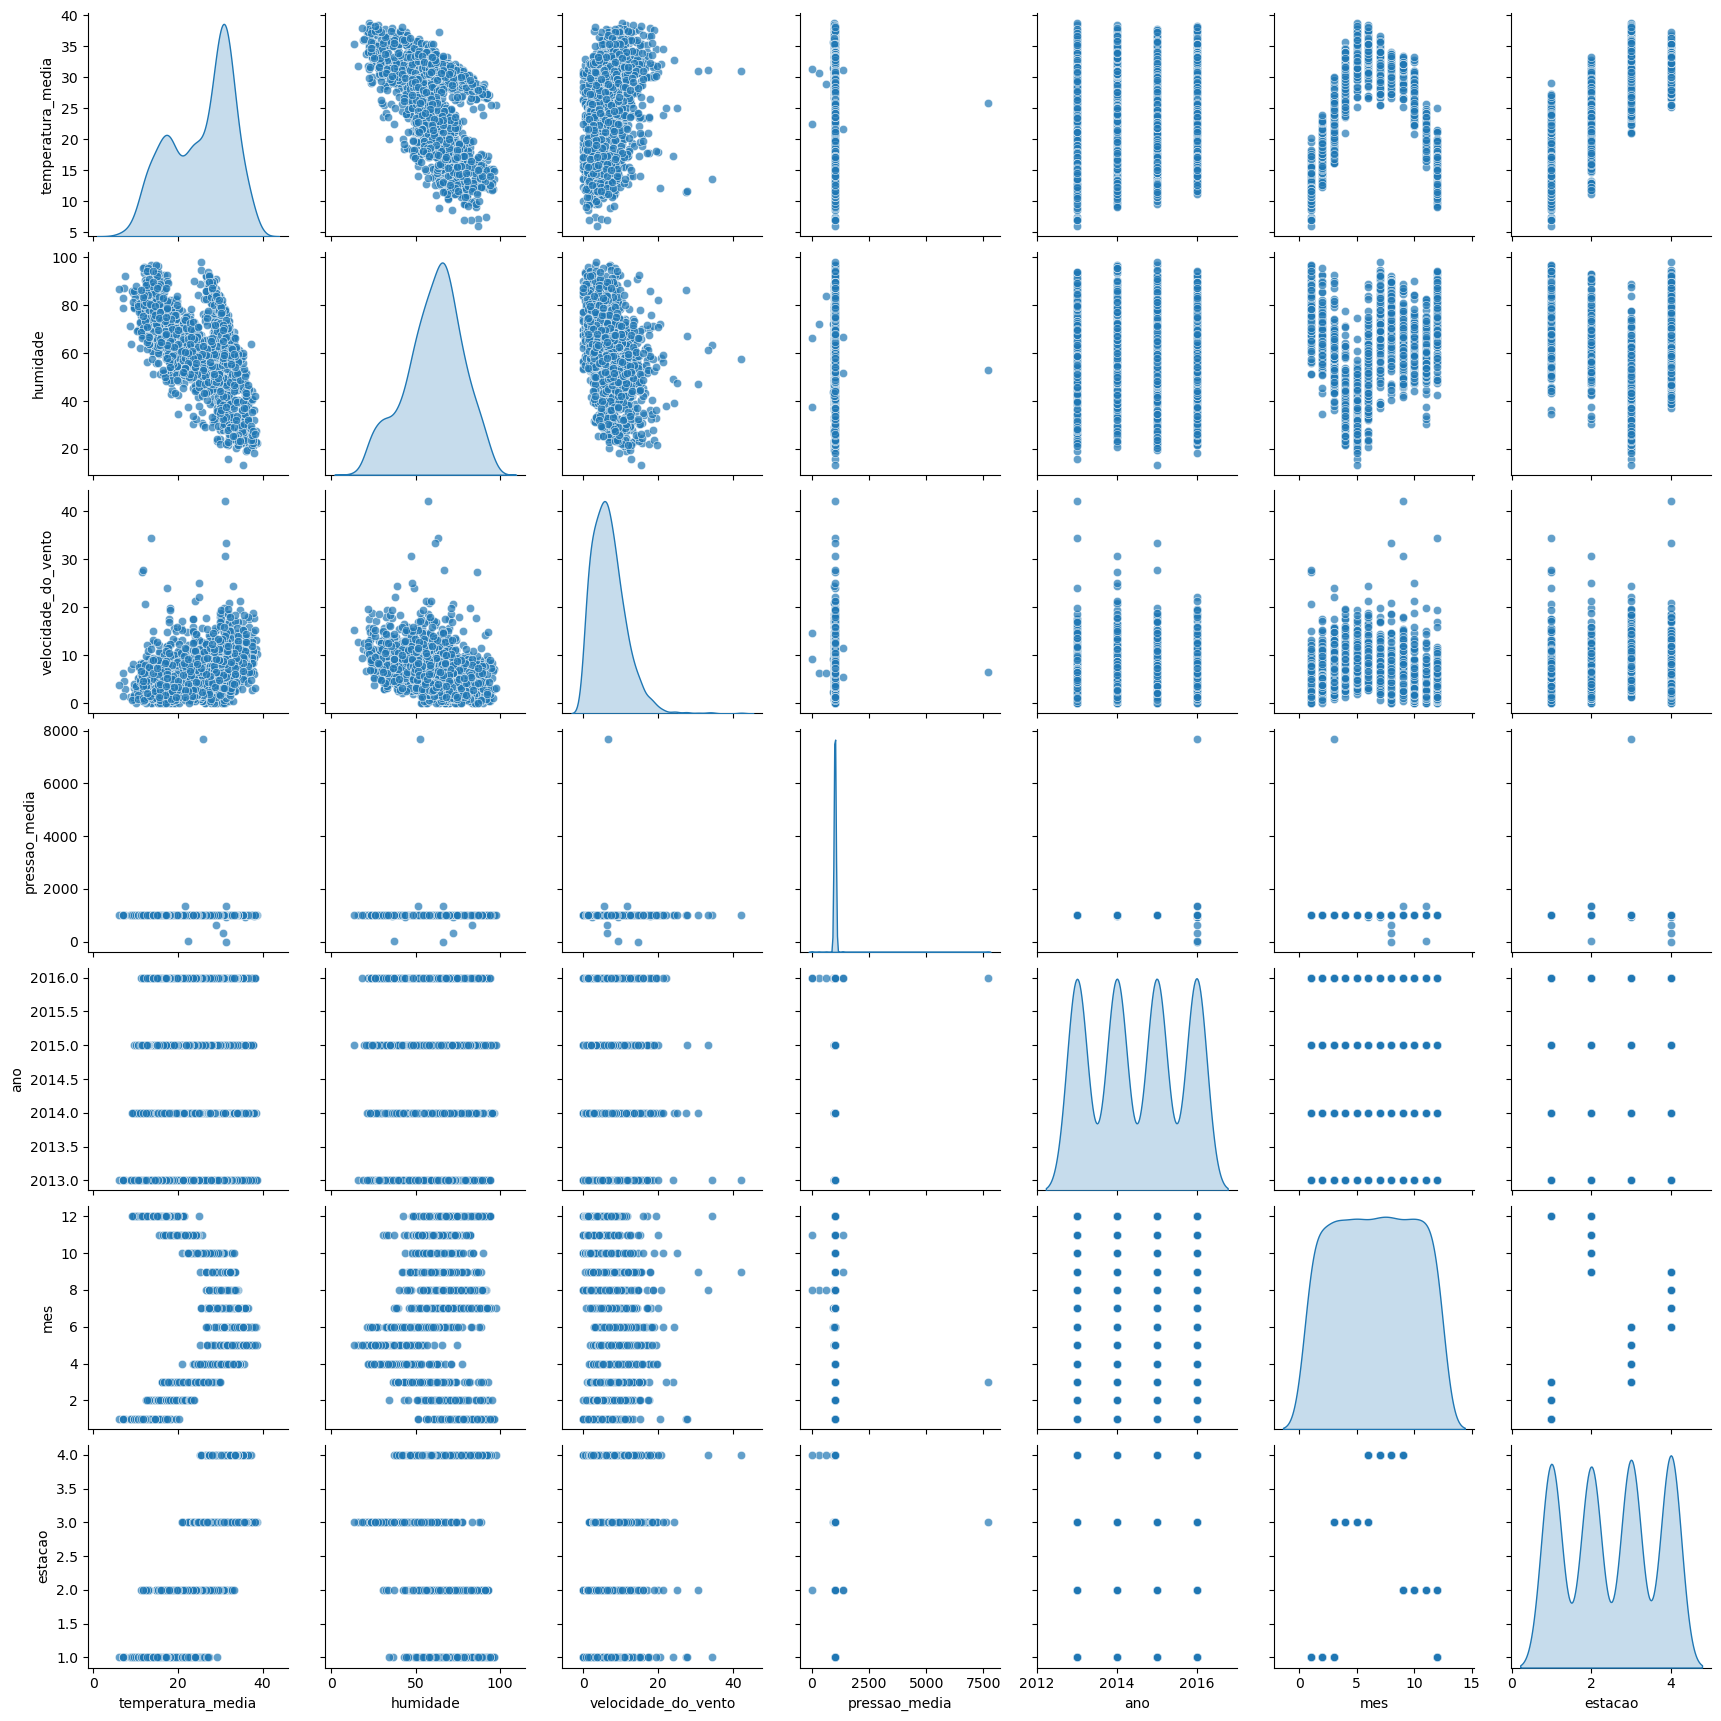

In [31]:
sns.pairplot(df, diag_kind='kde', plot_kws={'alpha':0.7})
plt.show()

## 4.8 Histogramas

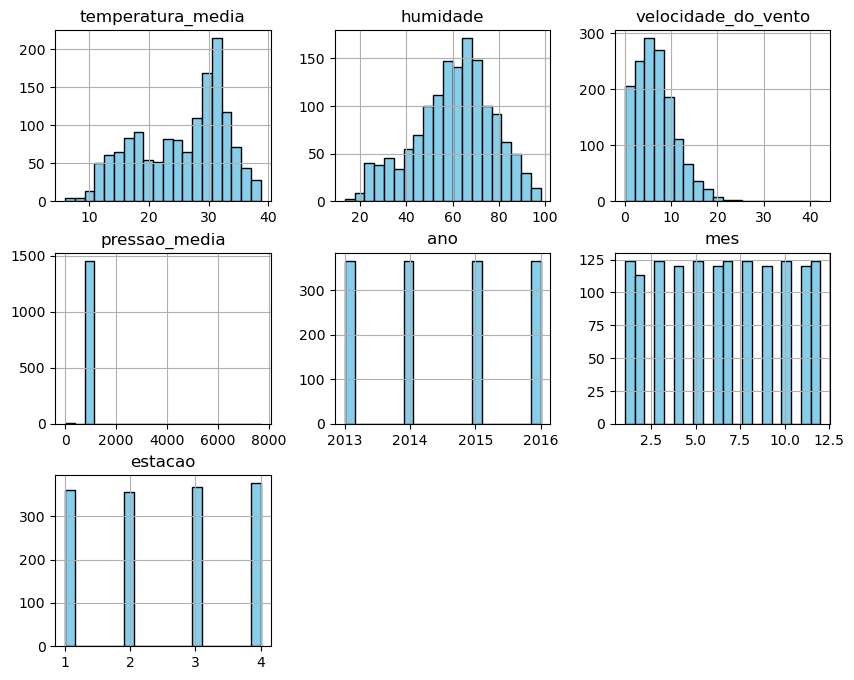

In [32]:
df.hist(figsize=(10, 8), bins=20, color='skyblue', edgecolor='black')
plt.show()

## 4.9 Exemplo de Média Móvel Exponencialmente Ponderada em 2013

É um tipo de filtro de resposta infinita ao impulso que aplica fatores de ponderação que diminuem exponencialmente. Ele dá mais peso às observações recentes enquanto reduz a influência dos pontos de dados mais antigos. Isso o torna muito útil na análise de séries temporais para suavizar dados, detectar tendências e fazer previsões.

In [33]:
df1 = df.iloc[:365, :]

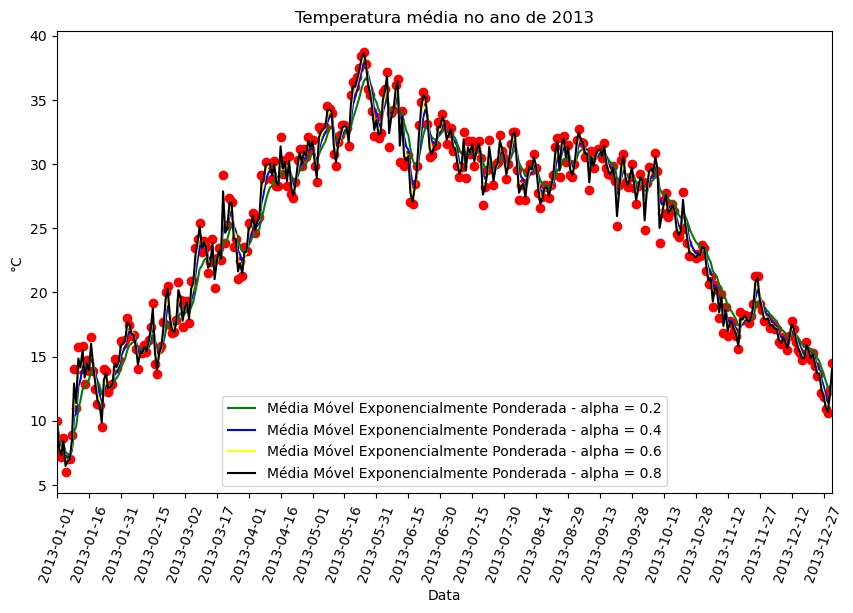

In [34]:
# Definindo as datas do eixo X a cada 15 dias
ticks = []
for i in range(len(df1.index)):
    if i%15 == 0:
        ticks.append(df1.index[i])

# Curvas de médias móveis exponecialmente ponderada
# Maiores valores de alpha dão mais peso aos valores mais recentes
curva1 = df1['temperatura_media'].ewm(alpha=0.2).mean()
curva2 = df1['temperatura_media'].ewm(alpha=0.4).mean()
curva3 = df1['temperatura_media'].ewm(alpha=0.6).mean()
curva4 = df1['temperatura_media'].ewm(alpha=0.8).mean()

plt.figure(figsize=(10, 6))
plt.title('Temperatura média no ano de 2013')
plt.xlabel('Data')
plt.ylabel('°C')
plt.scatter(df1.index, df1['temperatura_media'], color='red')
plt.plot(df1.index, curva1, color='green', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.2')
plt.plot(df1.index, curva2, color='blue', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.4')
plt.plot(df1.index, curva3, color='yellow', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.6')
plt.plot(df1.index, curva4, color='black', label = 'Média Móvel Exponencialmente Ponderada - alpha = 0.8')
plt.xticks(ticks = ticks, rotation='70')
plt.xlim(df1.index.min(),df1.index.max())
plt.legend()
plt.show()

# 5. Seleção de Features

Após essa análise, é possível afirmar que a pressão atmosférica, que sempre estará próxima de 1 atm, salvo erros de medição que aparentemente ocorreram em 2016, é uma váriavel descorrelacionada da temperatura e, portanto, estarei removendo-a e mantendo apenas as variáveis explicativas de humidade e velocidade do vento. Além disso, Mês e Estação do ano aparentam ter influência na temperatura e, por isso, também serão mantidos.

In [35]:
df.drop(['pressao_media','ano'], axis=1, inplace=True)

📝 <b> Target: </b> Temperatura Média (temperatura_media)  
📝 <b> Features mantidas: </b> Humidade (humidade), Velocidade do vento (velocidade_do_vento), Mês (mes), Estação do Ano (estacao)  
📝 <b> Features removidas: </b> Pressão Média (pressao_media), Ano (ano), Mês (mes)

# 6. Análise da Target (temperatura_media)

## 6.1 Teste de Estacionariedade

Avaliando a estacionariedade da série de temperatura média. Utilizando os testes estatísticos Augmented Dickey Fuller (ADF) e Kwiatkowski-Phillips-Schmidt-Shin (KPSS).

In [36]:
def teste_adf(serie):
    ''' Teste Augmented Dickey Fuller (ADF)
    
    I. Hipótese Nula: A série não estacionária.
    II. Hipótese Alternativa: Série estacionária.
    
    '''
    print("Resultados do teste Dickey-Fuller:")
    dftest = adfuller(serie, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Teste estatistico",
            "p-valor",
            "Quantidade de lags usados",
            "Número de observações usados",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput[f"Valor crítico ({key})"] = value
    print(dfoutput)
    
def teste_kpss(serie):
    '''  Kwiatkowski-Phillips-Schmidt-Shin (KPSS)
    
    I. Hipótese Nula: A série estacionária.
    II. Hipótese Alternativa: Série não estacionária.
    
    '''
    print("Resultados do teste KPSS:")
    kpsstest = kpss(serie, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Teste estatistico", "p-valor", "Lags usados"]
    )
    for key, value in kpsstest[3].items():
        kpss_output[f"Valor crítico ({key})"] = value
    print(kpss_output)

#### Teste Augmented Dickey Fuller ("ADF")

    I. Hipótese nula: A série tem raiz unitária (Série não estacionária).
    II. Hipótese alternativa: A série não tem raiz unitária. (Série estacionária).

In [37]:
teste_adf(df.temperatura_media)

Resultados do teste Dickey-Fuller:
Teste estatistico                 -2.155565
p-valor                            0.222766
Quantidade de lags usados         10.000000
Número de observações usados    1450.000000
Valor crítico (1%)                -3.434868
Valor crítico (5%)                -2.863535
Valor crítico (10%)               -2.567832
dtype: float64


<b> Conclusão ADF: </b> p-valor > 5% e, portanto, não se rejeita H0 => Série não estacionária.

#### Kwiatkowski-Phillips-Schmidt-Shin ("KPSS")

    I. Hipótese nula: O processo é estacionário em termos de tendência (Série estacionária).
    II. Hipótese alternativa: A série tem uma raiz unitária. (Série não estacionária).

In [38]:
teste_kpss(df.temperatura_media)

Resultados do teste KPSS:
Teste estatistico        0.191764
p-valor                  0.100000
Lags usados             25.000000
Valor crítico (10%)      0.347000
Valor crítico (5%)       0.463000
Valor crítico (2.5%)     0.574000
Valor crítico (1%)       0.739000
dtype: float64


C:\Users\Gamer\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


<b> Conclusão KPSS: </b> p-valor > 5% e, portanto, não se rejeita H0 => Série estacionária.

<b> Casos Possíveis: </b>  
* Caso 1: Ambos os testes concluem que a série não é estacionária - A série não é estacionária.  
* Caso 2: Ambos os testes concluem que a série é estacionária - A série é estacionária.  
* Caso 3: KPSS indica estacionariedade e ADF indica não estacionariedade - A série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária. A série sem tendência é verificada quanto à estacionariedade.  
* Caso 4: KPSS indica não estacionariedade e ADF indica estacionariedade - A série é estacionária por diferença. A diferenciação deve ser usada para tornar a série estacionária. A série diferenciada é verificada quanto à estacionariedade.

<b> Conclusão Final: </b> A série da temperatura se enquadra no caso 3. Portanto, a série é estacionária de tendência. A tendência precisa ser removida para tornar a série estritamente estacionária.

## 6.2 Tendência e Sazonalidade

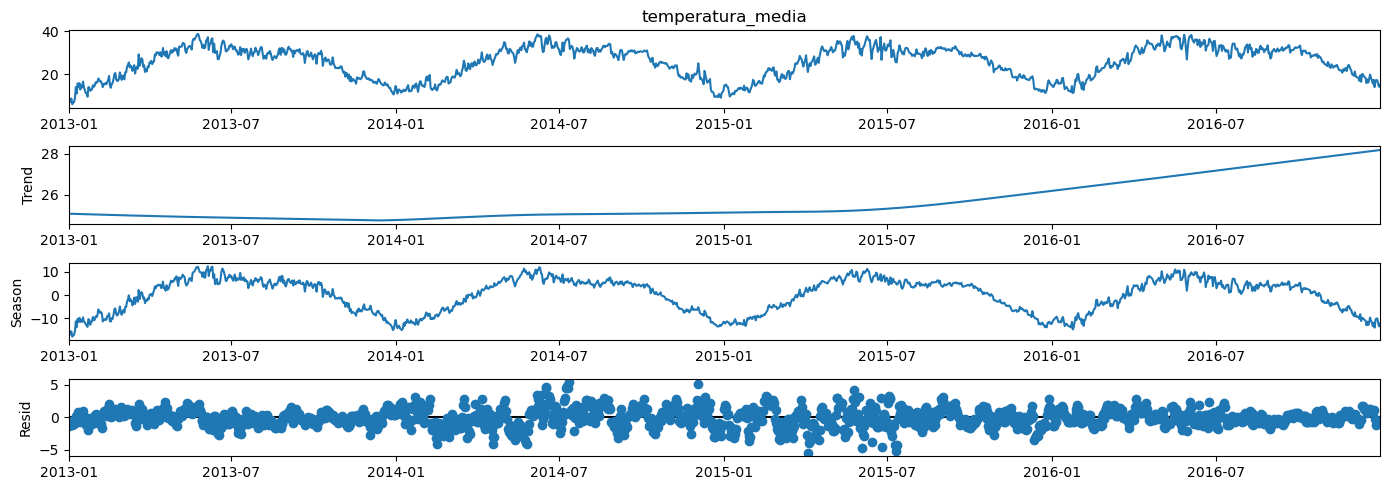

In [39]:
decomposicao = STL(df.temperatura_media, period=365).fit()
plt.rc("figure", figsize=(14,5))
decomposicao.plot()
plt.show()

#### Visualização dos resíduos

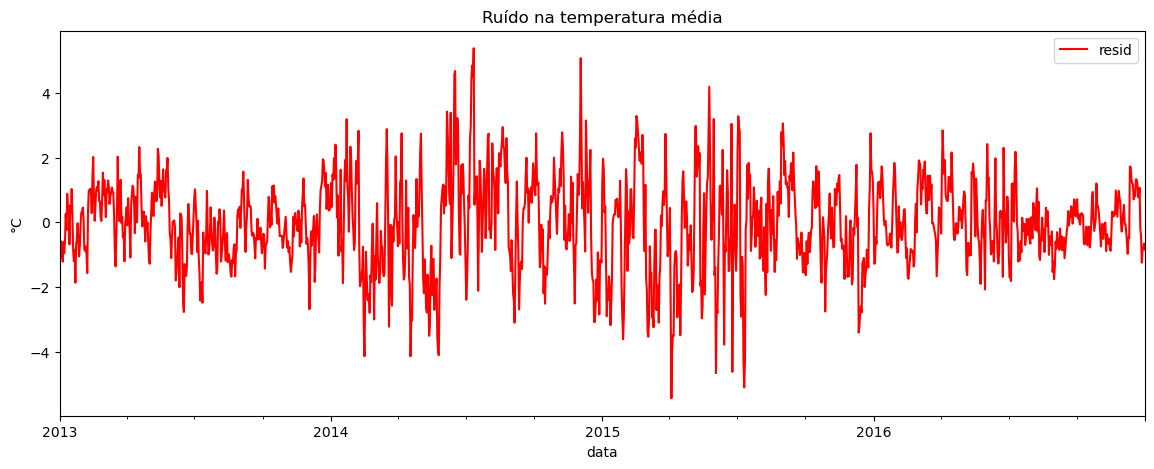

In [40]:
decomposicao.resid.plot(legend=True, color='red')
plt.title('Ruído na temperatura média')
plt.ylabel('°C')
plt.show()

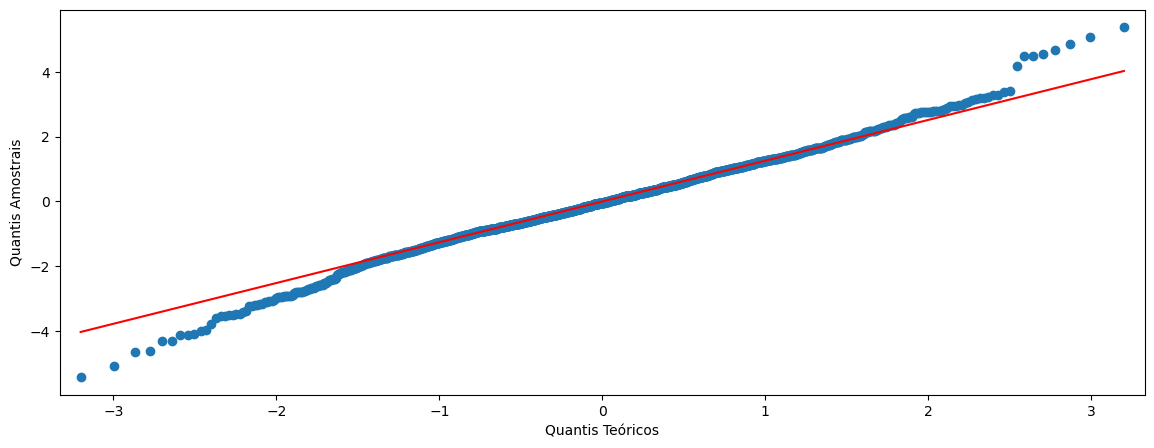

In [41]:
qqplot(decomposicao.resid, line = "q")
plt.xlabel('Quantis Teóricos')
plt.ylabel('Quantis Amostrais')
plt.show()

#### Sazonalidade média

In [42]:
df_sazonalidade = pd.DataFrame({'referencia': df.index, 'sazonalidade': decomposicao.seasonal})

df_sazonalidade['mes'] = pd.to_datetime(df_sazonalidade.referencia).dt.month
df_sazonalidade['ano'] = pd.to_datetime(df_sazonalidade.referencia).dt.year

sazonalidade_media_mes = df_sazonalidade.groupby('mes')['sazonalidade'].mean()
sazonalidade_media_ano = df_sazonalidade.groupby('ano')['sazonalidade'].mean()

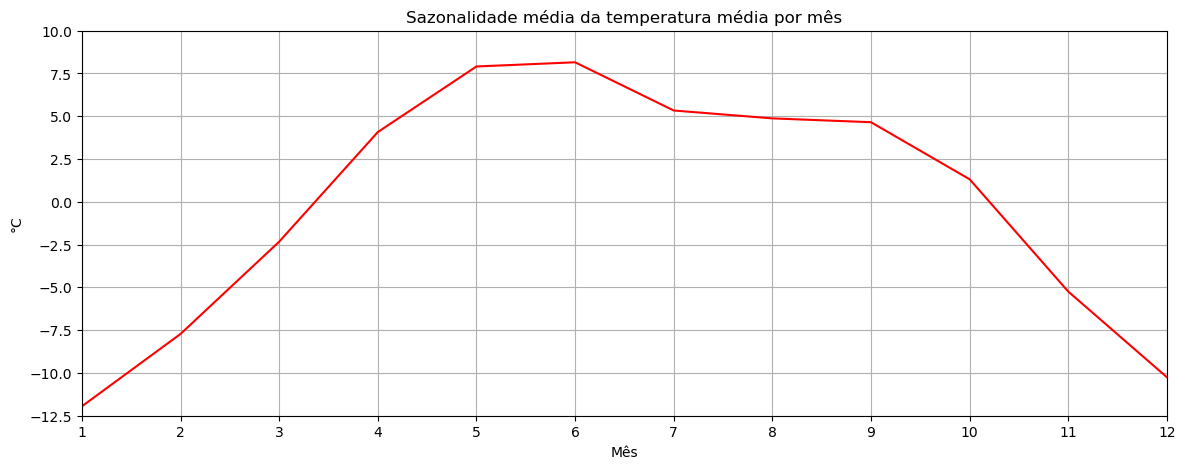

In [43]:
plt.figure(figsize = (14,5))
plt.plot(sazonalidade_media_mes.index, sazonalidade_media_mes.values, color ='red')
plt.title('Sazonalidade média da temperatura média por mês')
plt.ylabel('°C')
plt.xlabel('Mês')
plt.xticks(range(1,13))
plt.ylim(-12.5,10)
plt.xlim(1,12)
plt.grid(True)
plt.show()

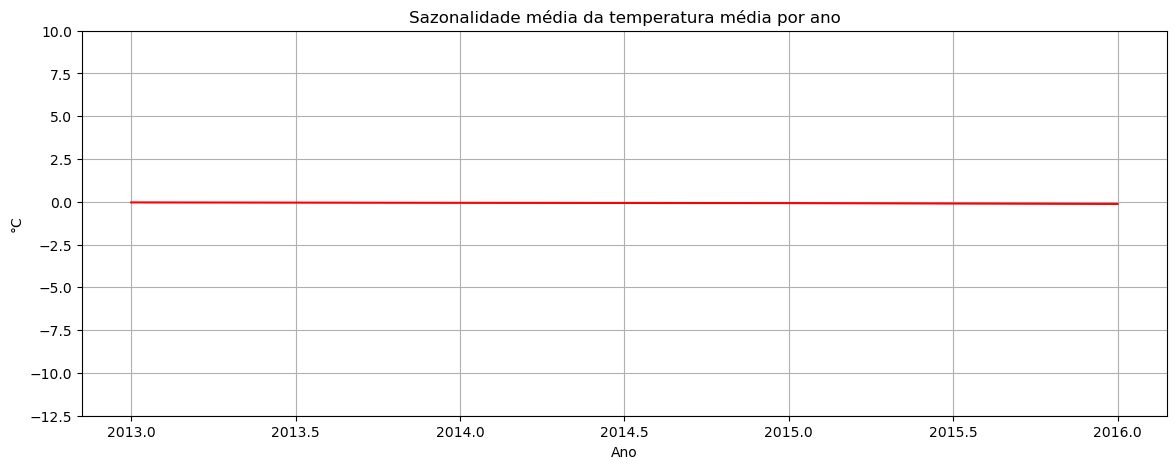

In [44]:
plt.figure(figsize = (14,5))
plt.plot(sazonalidade_media_ano.index, sazonalidade_media_ano.values, color = 'red')
plt.title('Sazonalidade média da temperatura média por ano')
plt.ylabel('°C')
plt.xlabel('Ano')
plt.ylim(-12.5,10)
plt.grid(True)
plt.show()

## 6.3 Função de Autocorrelação (ACF)

- A ACF mede a correlação entre uma série temporal e seus valores defasados em diferentes intervalos de defasagem.
- No eixo x, você tem a defasagem ou o intervalo de tempo.
- O eixo y representa o coeficiente de correlação, que varia de -1 a 1.
- Valores positivos indicam correlação positiva (movimento similar na mesma direção), enquanto valores negativos indicam correlação negativa (movimento oposto).
- A região sombreada representa o intervalo de confiança de 95%. Valores de correlação fora desta região são considerados estatisticamente significativos.
- Picos significativos no gráfico da ACF indicam possíveis padrões sazonais ou tendências nos dados.

#### Visão de 1 Mês

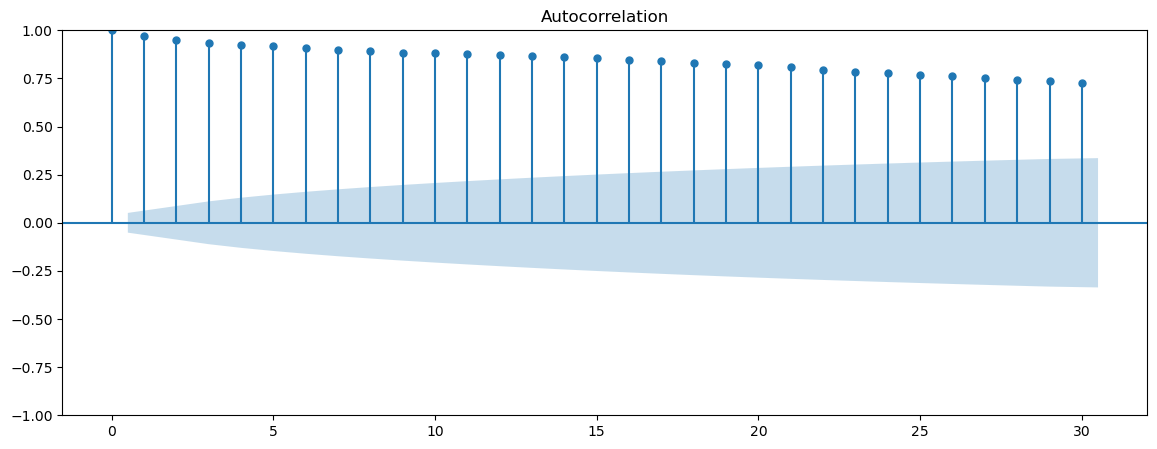

In [45]:
plot_acf(df.temperatura_media.values, lags=30)
plt.show()

#### Visão de 3 Meses

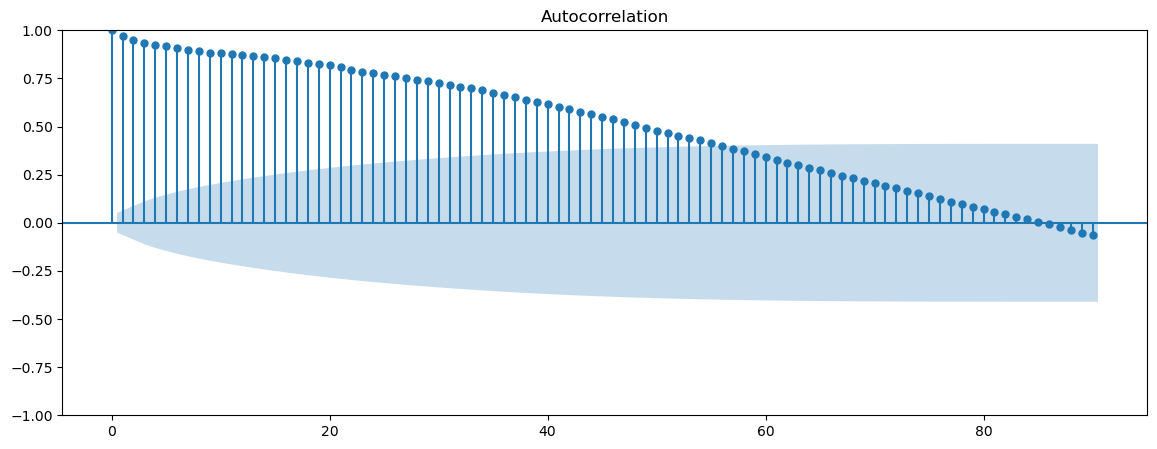

In [46]:
plot_acf(df.temperatura_media.values, lags=90)
plt.show()

#### Visão de 6 Meses

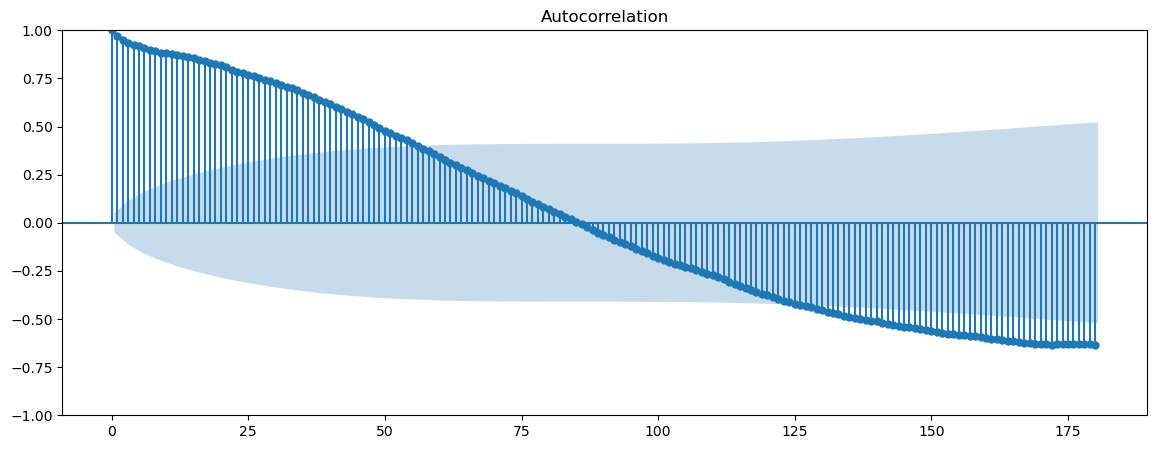

In [47]:
plot_acf(df.temperatura_media.values, lags=180)
plt.show()

#### Visão de 1 Ano

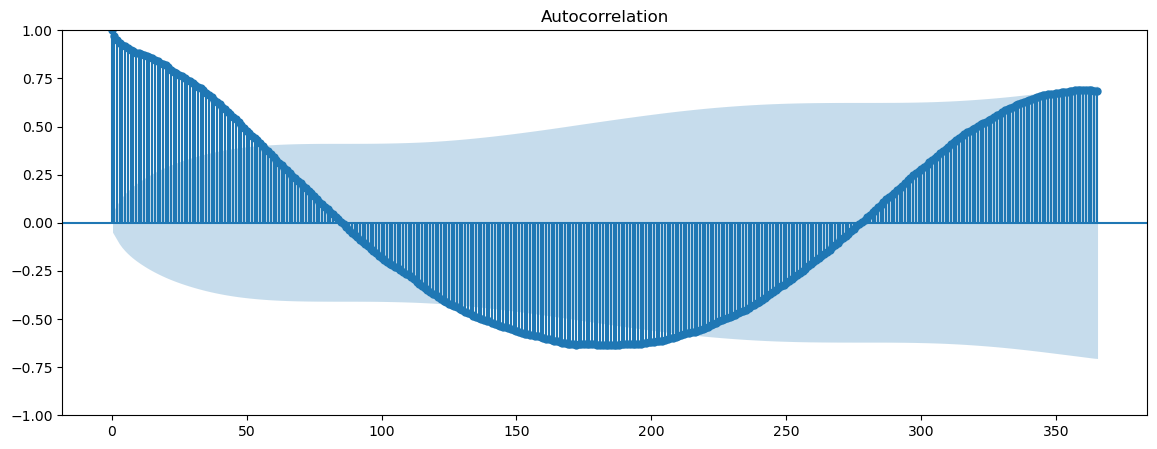

In [48]:
plot_acf(df.temperatura_media.values, lags=365)
plt.show()

#### Visão de 2 anos

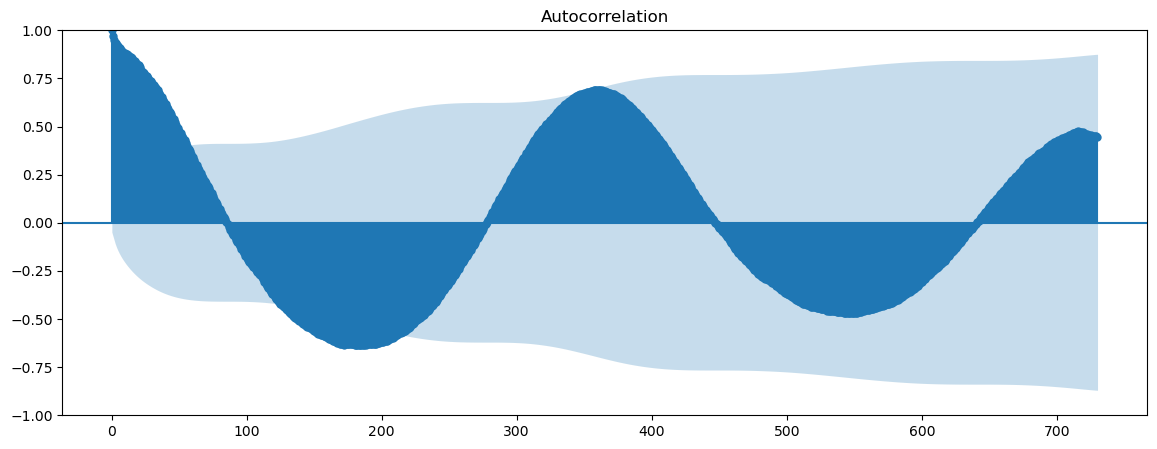

In [49]:
plot_acf(df.temperatura_media.values, lags=730)
plt.show()

#### Visão de 3 anos

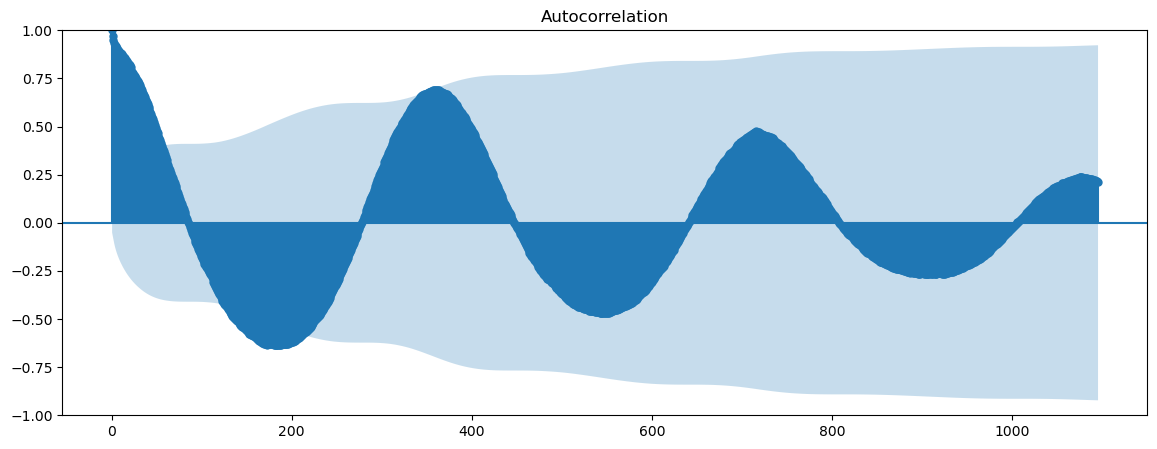

In [50]:
plot_acf(df.temperatura_media.values, lags=1095)
plt.show()

#### Visão com todo os dados de treino

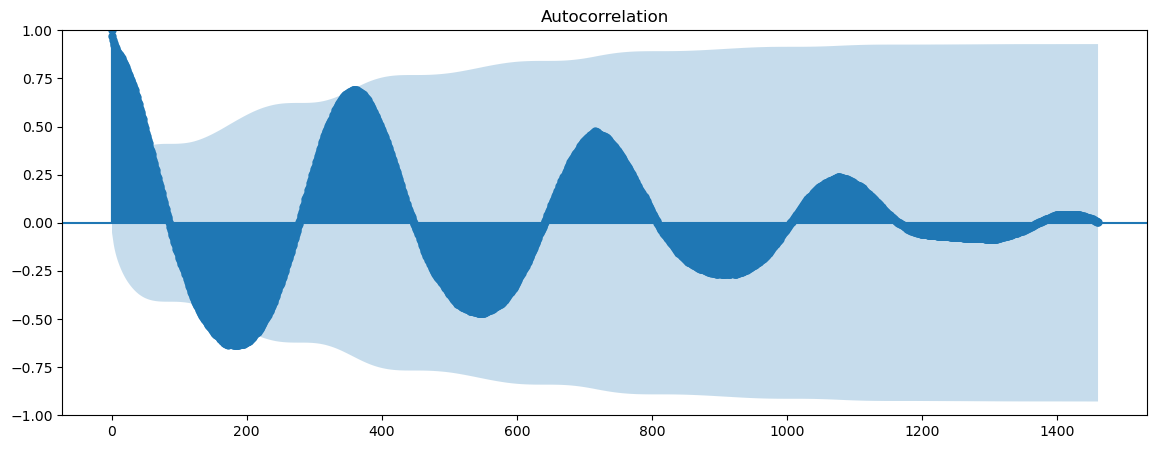

In [51]:
plot_acf(df.temperatura_media.values, lags=1460)
plt.show()

📝 A Função ACF indica que existe uma dependência temporal da temperatura com valores passados.

## 6.4 Função de Autocorrelação Parcial (PACF)

- A PACF mede a correlação entre uma série temporal e seus valores defasados, controlando os efeitos de outras defasagens intermediárias.
- Ela ajuda a identificar a relação direta entre um ponto de dados e seus valores defasados, excluindo a influência de outras defasagens.
- Semelhante ao gráfico da ACF, o eixo x representa a defasagem ou o intervalo de tempo, e o eixo y representa o coeficiente de correlação.
- Picos significativos no gráfico da PACF indicam o número de termos defasados a serem incluídos em modelos autorregressivos (AR).
- Interpretar esses gráficos ajuda a identificar possíveis padrões, tendências e sazonalidade nos dados de séries temporais, fornecendo insights para modelagem e previsão.

#### Visão de 1 mês

C:\Users\Gamer\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


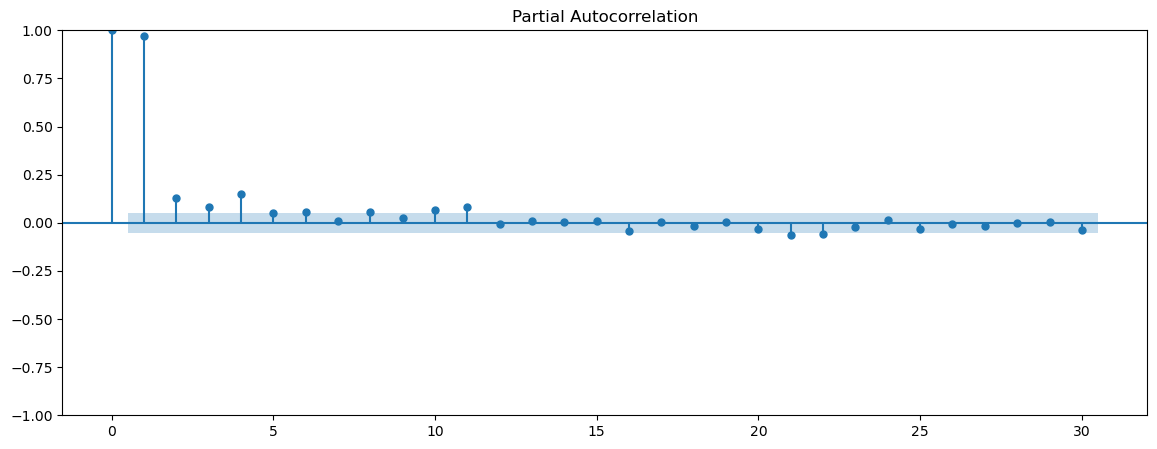

In [52]:
plot_pacf(df.temperatura_media.values, lags=30)
plt.show()

#### Visão de 3 Meses

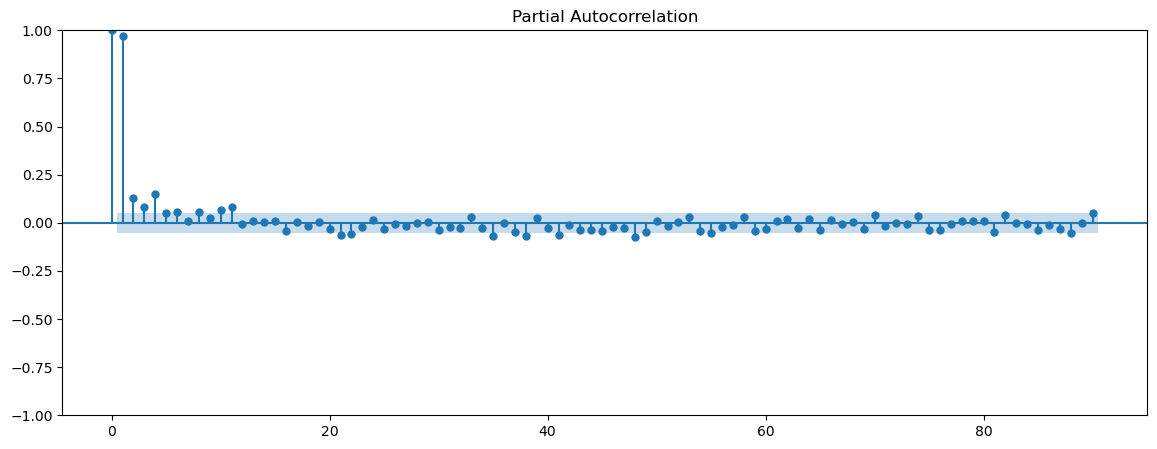

In [53]:
plot_pacf(df.temperatura_media.values, lags=90)
plt.show()

#### Visão de 6 Meses

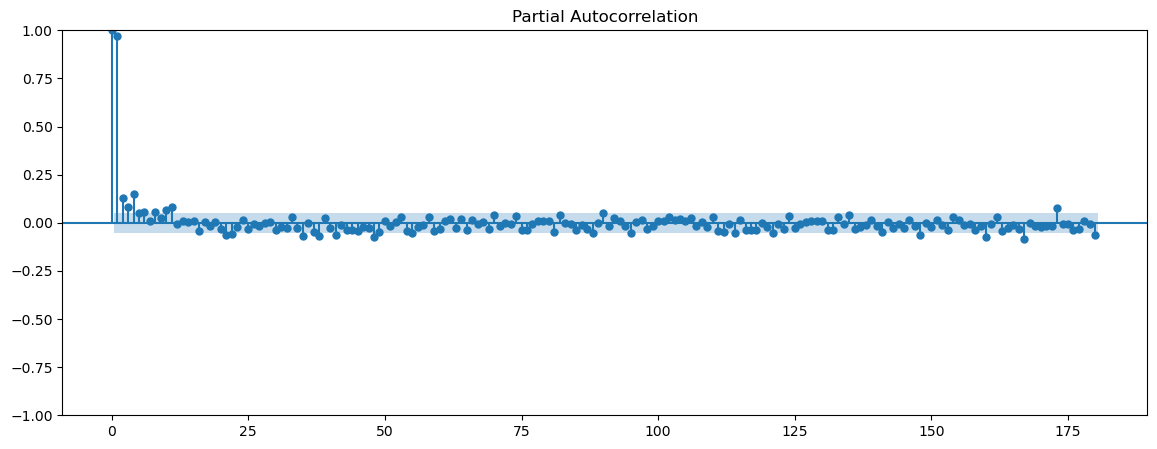

In [54]:
plot_pacf(df.temperatura_media.values, lags=180)
plt.show()

#### Visão de 1 Ano

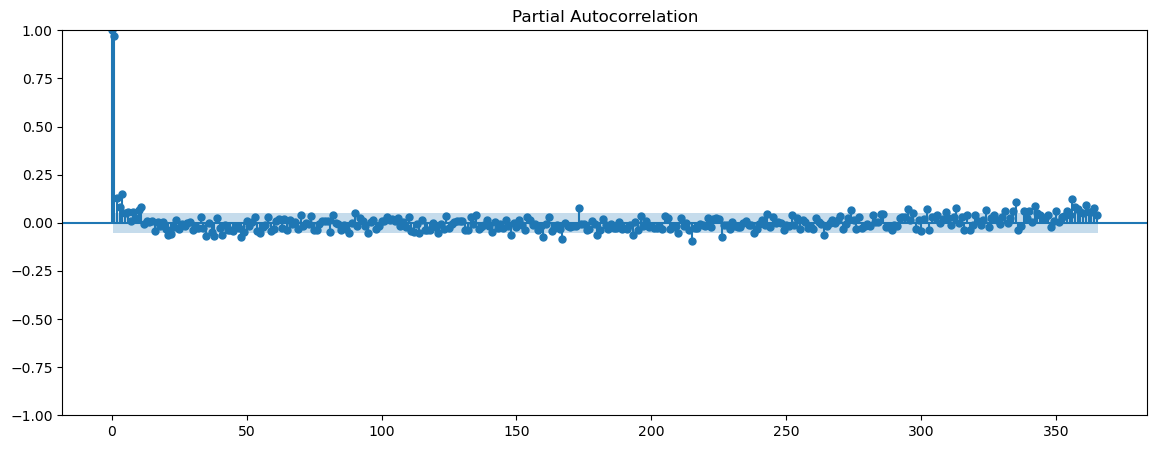

In [55]:
plot_pacf(df.temperatura_media.values, lags=365)
plt.show()

#### Visão de 2 anos

Maior possível, pois usando todos os dados de treino temos que 1460/2 = 730

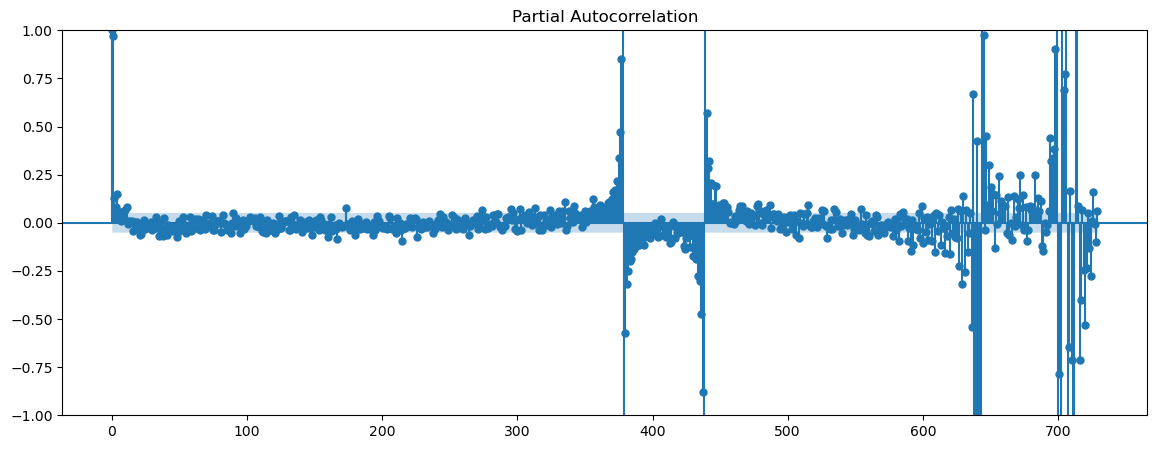

In [56]:
plot_pacf(df.temperatura_media.values, lags=729)
plt.show()

# 7. Preparação dos Dados

Obtendo dados mensais (Média de cada um dos meses).

In [57]:
m_df = df.resample('M').mean()

Separação dos dados de Treino e Teste:

In [58]:
tamanho_do_treino = int(len(m_df) * 0.7)
treino, teste = m_df.iloc[:tamanho_do_treino], m_df.iloc[tamanho_do_treino:]

# 8. Treinamento dos Modelos

## 8.1 ARIMA-SARIMA-SARIMAX

### Parâmetros "p", "d" e "q"

- p:  
 - p é a ordem do termo Auto Regressivo (AR). Refere-se ao número de defasagens de Y a serem usadas como preditores.

- d:  
 - O termo Auto Regressivo no ARIMA significa que é um modelo de regressão linear que usa suas próprias defasagens como preditores. Modelos de regressão linear, como sabemos, funcionam melhor quando os preditores não são correlacionados e são independentes uns dos outros. Portanto, precisamos tornar a série temporal estacionária.

 - A abordagem mais comum para tornar a série estacionária é diferenciá-la. Ou seja, subtrair o valor anterior do valor atual. Às vezes, dependendo da complexidade da série, mais de uma diferenciação pode ser necessária.

 - O valor de d, portanto, é o número mínimo de diferenciações necessárias para tornar a série estacionária. Se a série temporal já for estacionária, então d = 0.

- q:  
 - q é a ordem do termo de Média Móvel (MA). Refere-se ao número de erros de previsão defasados que devem ser incluídos no modelo ARIMA.


## 8.2 Auto ARIMA

A função auto_arima irá automaticamente buscar combinações desses parâmetros dentro dos intervalos especificados para encontrar o modelo de melhor ajuste com base em critérios como o AIC (Critério de Informação de Akaike). Ao definir esses valores máximos (max_p, max_d, max_q, max_P, max_D, max_Q), você está especificando os limites dentro dos quais o auto_arima fará a busca.

Sazonalizada anual com dados mensais, portanto m, que é a frequência, é igual a 12.

### SARIMA

Modelo ARIMA com Sazonalidade.

In [59]:
modelo = pm.auto_arima(y = treino.temperatura_media,
                       start_p = 0, start_q = 0,
                       start_P = 0, start_Q = 0,
                       max_d = 1, max_p = 8, max_q = 4,
                       max_P=4, max_D=1, max_Q=3,
                       seasonal = True, m=12, test='adf',
                       trace=2, n_jobs=-1, random_state=42, error_action='ignore',
                       n_fits=10, stepwise=False, maxiter=100)


Best model:  ARIMA(2,1,0)(1,1,0)[12]          
Total fit time: 23.490 seconds


In [60]:
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   33
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 12)   Log Likelihood                 -35.013
Date:                            Wed, 17 Jul 2024   AIC                             78.026
Time:                                    23:52:36   BIC                             82.009
Sample:                                01-31-2013   HQIC                            78.803
                                     - 09-30-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5743      0.326     -1.760      0.078      -1.214       0.065
ar.L2         -0.4042      0.358     -1.129      0.259      -1.106       0.297
ar.S.L12      -0.7637      0.177     -4.303      0.000      -1.111      -0.416
sigma2         1.1184      0.859      1.303      0.193      -0.564       2.801
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.90
Prob(Q):                              0.93   Prob(JB):                         0.64
Heteroskedasticity (H):               0.51   Skew:                             0.52
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

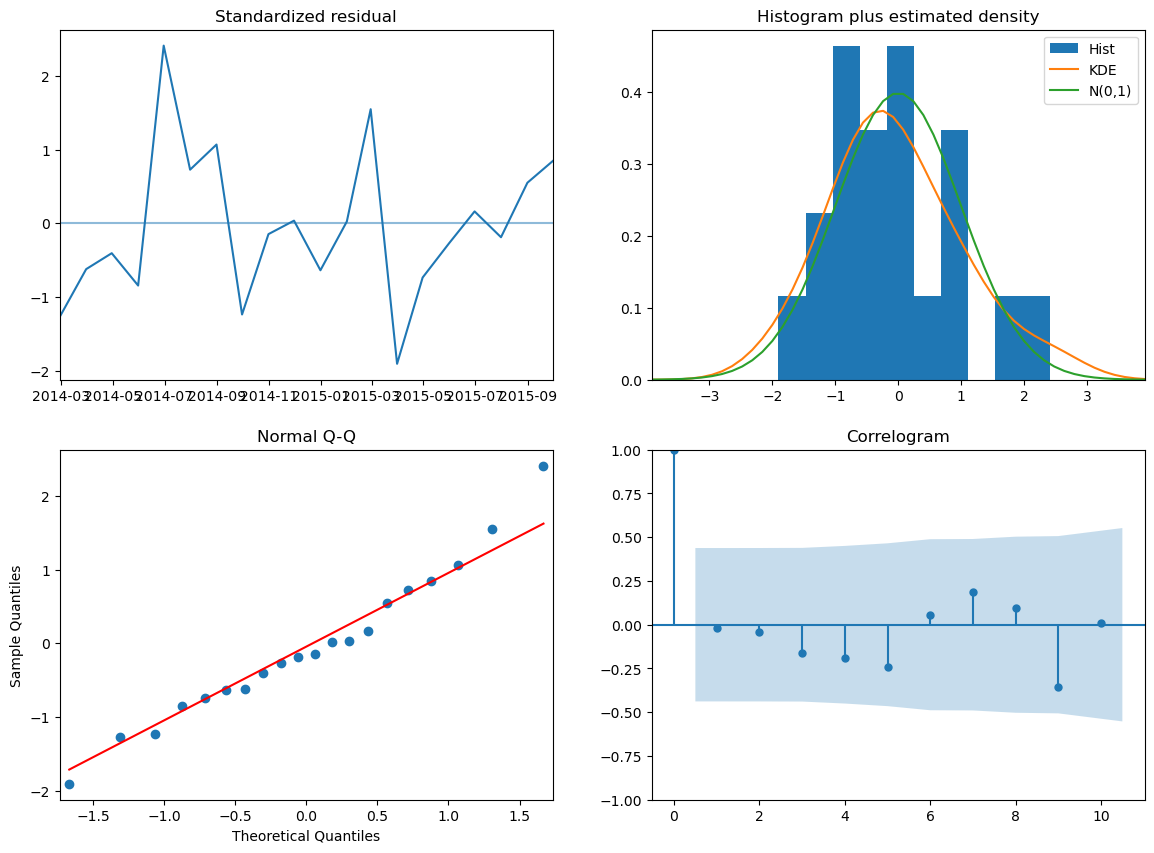

In [61]:
modelo.plot_diagnostics(figsize=(14,10))
plt.show()

In [62]:
n_periodos = len(teste)
auto_arima_pred  = modelo.predict(n_periods=n_periodos)

Métricas de teste:

In [63]:
# Métricas R2, MSE e RMSE
r2 = r2_score(teste.temperatura_media, auto_arima_pred)
mse = mean_squared_error(teste.temperatura_media, auto_arima_pred)
rmse = np.sqrt(mean_squared_error(teste.temperatura_media, auto_arima_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo.aic())

R2 score: 0.9046170171314495
MSE: 4.3389197176555685
RMSE: 2.083007373404033
AIC: 78.025750820094


Previsão do modelo para dados de teste:

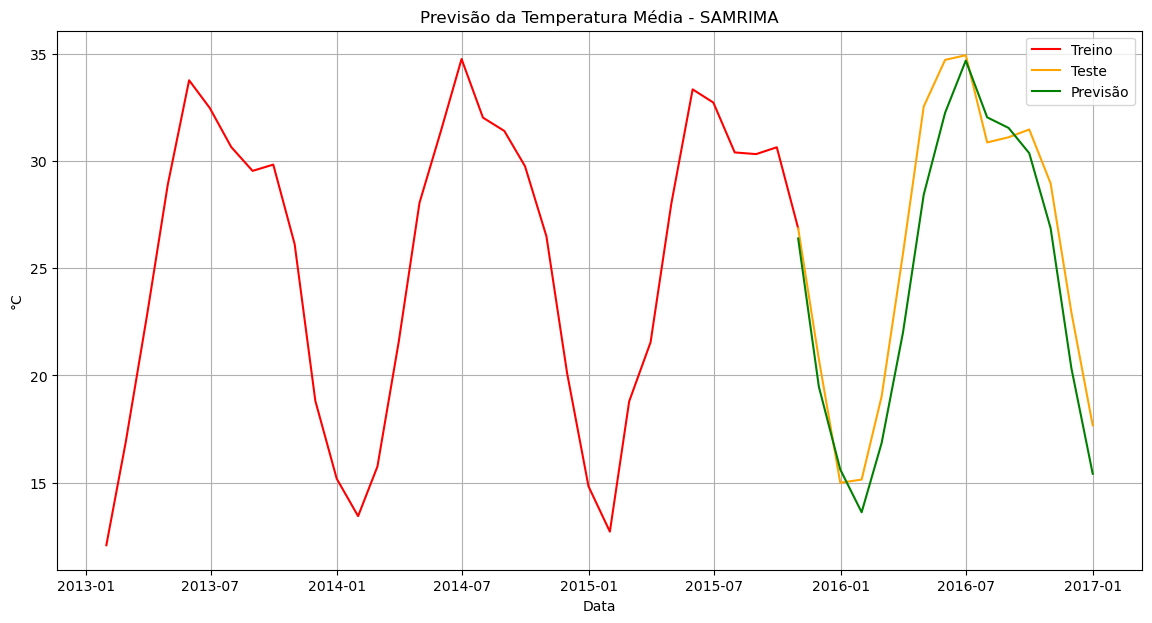

In [64]:
# Ajustando a quebra do gráfico
treino_x = treino.index.tolist()
treino_x.append(teste.index[0])
treino_y = treino.temperatura_media.tolist()
treino_y.append(teste.temperatura_media[0])

plt.figure(figsize=(14, 7))
plt.plot(treino_x, treino_y, label='Treino', color='red')
plt.plot(teste.index, teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(teste.index, auto_arima_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMA')
plt.grid(True)
plt.show()

### SARIMAX

Modelo SARIMA com variáveis exógenas.

In [65]:
modelo1 = pm.auto_arima(y = treino.temperatura_media, X=treino[['humidade','velocidade_do_vento','mes', 'estacao']],
                       start_p = 0, start_q = 0,
                       start_P = 0, start_Q = 0,
                       max_d = 1, max_p = 8, max_q = 4,
                       max_P=4, max_D=1, max_Q=3,
                       seasonal = True, m=12, test='adf',
                       trace=2, n_jobs=-1, random_state=42, error_action='ignore',
                       n_fits=10, stepwise=False, maxiter=100)


Best model:  ARIMA(0,1,1)(2,0,0)[12] intercept
Total fit time: 28.176 seconds


In [66]:
modelo1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   33
Model:             SARIMAX(0, 1, 1)x(2, 0, [], 12)   Log Likelihood                 -54.287
Date:                             Wed, 17 Jul 2024   AIC                            126.574
Time:                                     23:53:05   BIC                            139.766
Sample:                                 01-31-2013   HQIC                           130.947
                                      - 09-30-2015                                         
Covariance Type:                               opg                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
intercept            9.445e-05      0.000      0.199      0.843      -0.001       0.001
humidade               -0.0905      0.022     -4.028      0.000      -0.135      -0.046
velocidade_do_vento     0.0758      0.236      0.322      0.748      -0.386       0.538
mes                    -0.1643      0.308     -0.533      0.594      -0.768       0.439
estacao                 5.8932      0.909      6.485      0.000       4.112       7.674
ma.L1                  -0.9720      0.152     -6.408      0.000      -1.269      -0.675
ar.S.L12                0.1563      0.223      0.702      0.483      -0.280       0.593
ar.S.L24                0.8268      0.238      3.477      0.001       0.361       1.293
sigma2                  0.3703      0.362      1.024      0.306      -0.338       1.079
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 1.55
Prob(Q):                              0.83   Prob(JB):                         0.46
Heteroskedasticity (H):               0.97   Skew:                             0.49
Prob(H) (two-sided):                  0.97   Kurtosis:                         2.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

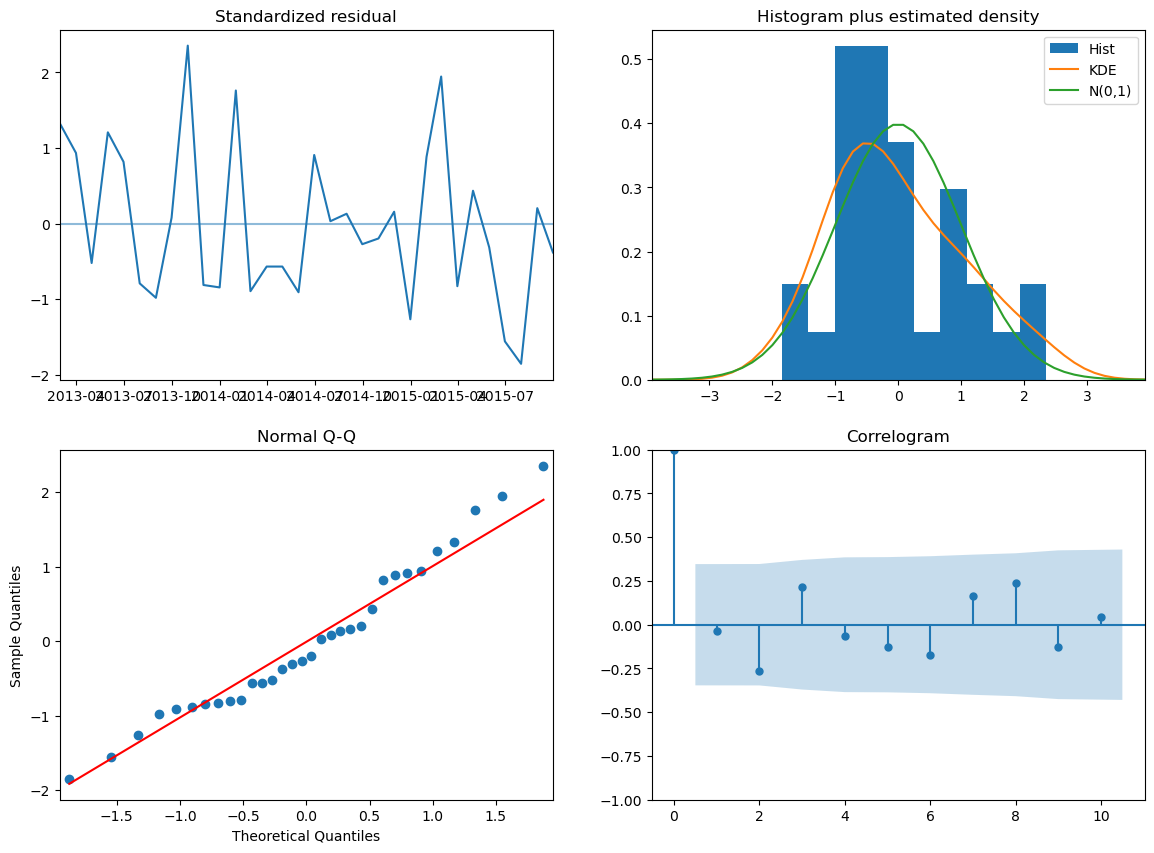

In [67]:
modelo1.plot_diagnostics(figsize=(14,10))
plt.show()

In [68]:
n_periodos = len(teste)
auto_arima_pred  = modelo1.predict(n_periods=n_periodos, X = teste[['humidade','velocidade_do_vento','mes','estacao']])

Métricas de teste:

In [69]:
# Métricas R2, MSE e RMSE
r2 = r2_score(teste.temperatura_media, auto_arima_pred)
mse = mean_squared_error(teste.temperatura_media, auto_arima_pred)
rmse = np.sqrt(mean_squared_error(teste.temperatura_media, auto_arima_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo1.aic())

R2 score: 0.9197051572583491
MSE: 3.6525684762651047
RMSE: 1.911169400201119
AIC: 126.57437246179305


Previsão do modelo para dados de teste:

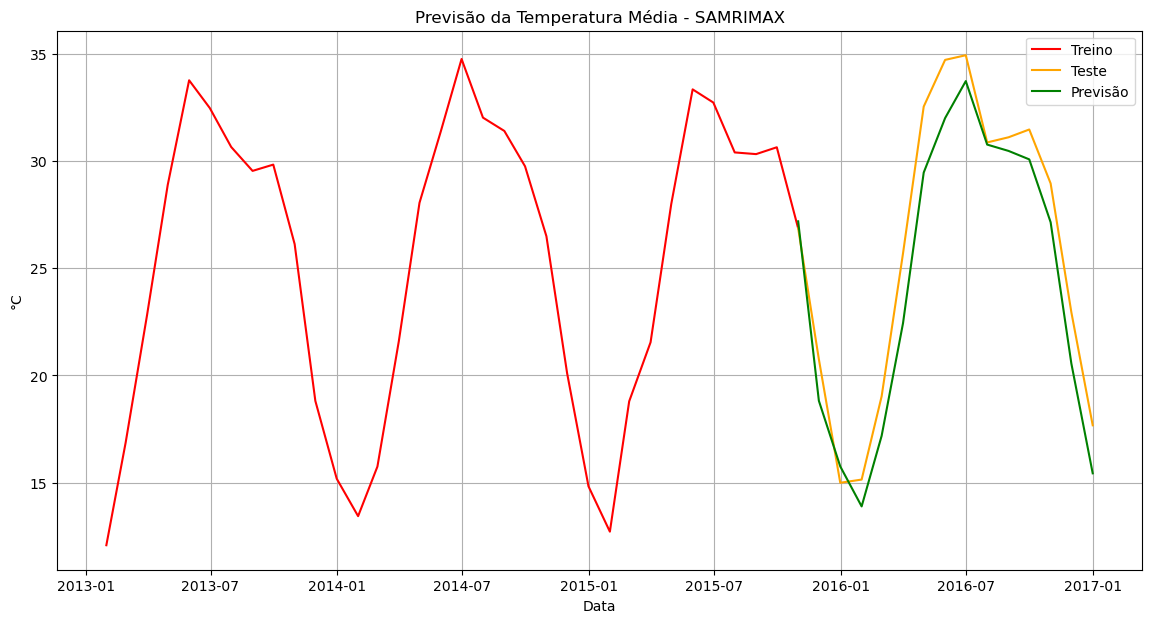

In [70]:
# Ajustando a quebra do gráfico
treino_x = treino.index.tolist()
treino_x.append(teste.index[0])
treino_y = treino.temperatura_media.tolist()
treino_y.append(teste.temperatura_media[0])

plt.figure(figsize=(14, 7))
plt.plot(treino_x, treino_y, label='Treino', color='red')
plt.plot(teste.index, teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(teste.index, auto_arima_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMAX')
plt.grid(True)
plt.show()

## 8.3 Prophet

O algoritmo Prophet funciona com as variáveis "ds" e "y" como entradas. Vamos ajustar nossos conjuntos de treinamento e teste de acordo.

- <b> ds: </b> Esta coluna contém as datas. No Prophet, as datas nesta coluna são tipicamente em frequência diária, embora isso não seja obrigatório. As datas podem estar no formato AAAA-MM-DD (por exemplo, "2024-04-01") ou em formato de timestamp.

- <b>y: </b> Esta coluna contém os valores observados que você deseja prever. Por exemplo, se você deseja prever o número diário de visitantes a um site, a coluna "y" conterá esses números de visitantes.

- <b>yhat: </b> Este é o valor principal previsto pelo modelo. Em outras palavras, é o valor que seu modelo prevê que a série temporal terá para um valor específico de "ds" (data).

- <b>yhat_lower e yhat_upper: </b> Esses valores representam o intervalo de incerteza das previsões. O Prophet leva em conta a incerteza ao fazer previsões, estimando com alta confiança que o valor verdadeiro estará dentro desse intervalo. Por exemplo, se yhat_lower for 30 e yhat_upper for 40, isso significa que o modelo prevê com confiança que o valor verdadeiro estará dentro desse intervalo.

#### Preparação dos Dados

Ajustando os nomes das colunas para o formato esperado pelo Prophet.

In [71]:
p_df = df.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

tamanho_do_treino = int(len(p_df) * 0.7)
p_treino, p_teste = p_df.iloc[:tamanho_do_treino], p_df.iloc[tamanho_do_treino:]

#### Prophet1 - Treinando Modelo Apenas com a Série

In [72]:
modelo_p = Prophet()

modelo_p.fit(p_treino)

futuro = modelo_p.make_future_dataframe(periods=len(p_teste), freq='D')

previsao = modelo_p.predict(futuro)

predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_teste['ds']]

23:53:07 - cmdstanpy - INFO - Chain [1] start processing
23:53:07 - cmdstanpy - INFO - Chain [1] done processing


R2 score: 0.8269974909431795
MSE: 8.95719918767104
RMSE: 2.9928580299892342


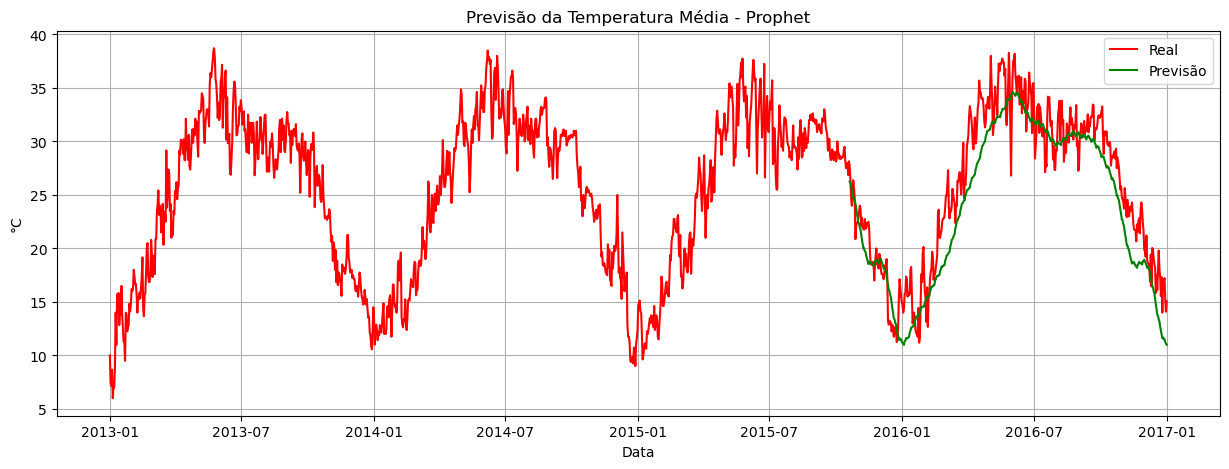

In [73]:
r2 = r2_score(p_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df['ds'], p_df['y'], color='red', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet')
plt.legend()
plt.grid(True)
plt.show()

#### Prophet2 - Treinando o Modelo com as demais Features (Humidade, Velocidade do Vento, Mês e Estação)

In [74]:
p_df = df.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [75]:
modelo_p2 = Prophet()
modelo_p2.add_regressor('humidade')
modelo_p2.add_regressor('velocidade_do_vento')
modelo_p2.add_regressor('mes')
modelo_p2.add_regressor('estacao')

modelo_p2.fit(p_treino)

futuro = modelo_p2.make_future_dataframe(periods=len(p_teste), freq='D')

futuro['humidade'] = df['humidade'].values
futuro['velocidade_do_vento'] = df['velocidade_do_vento'].values
futuro['mes'] = df['mes'].values
futuro['estacao'] = df['estacao'].values

previsao = modelo_p2.predict(futuro)

predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_teste['ds']]

23:53:08 - cmdstanpy - INFO - Chain [1] start processing
23:53:09 - cmdstanpy - INFO - Chain [1] done processing


R2 score: 0.8785970559376379
MSE: 6.2856334157506915
RMSE: 2.5071165540817386


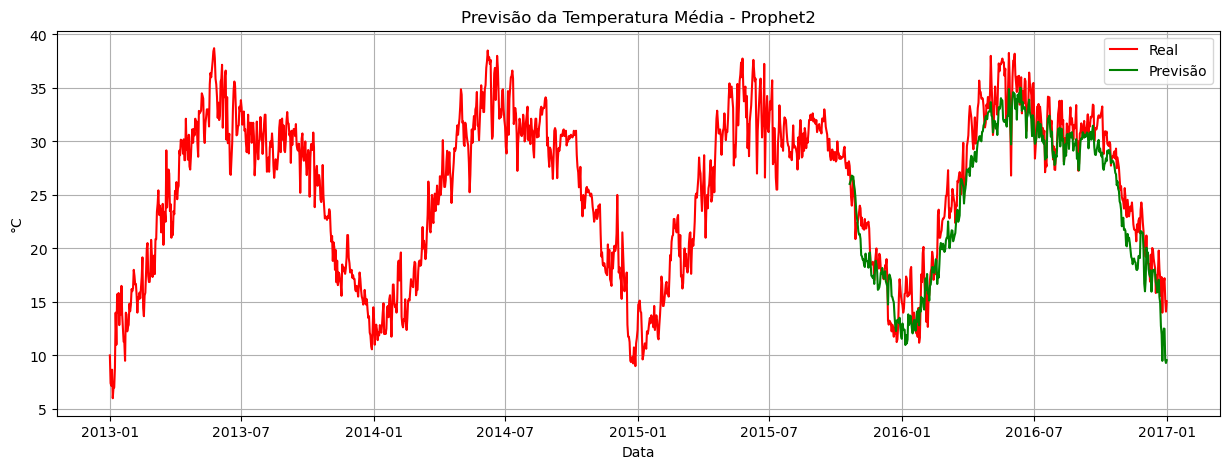

In [76]:
r2 = r2_score(p_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df['ds'], p_df['y'], color='red', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet2')
plt.grid(True)
plt.legend()
plt.show()

# 9. Teste e Projeções dos Modelos

## 9.1 SARIMA

In [77]:
n_periodos = len(df_teste)
sarima_pred  = modelo.predict(n_periods=n_periodos)

R2 score: -1.5384106578015162
MSE: 101.77931376014799
RMSE: 10.088573425422842
AIC: 78.025750820094


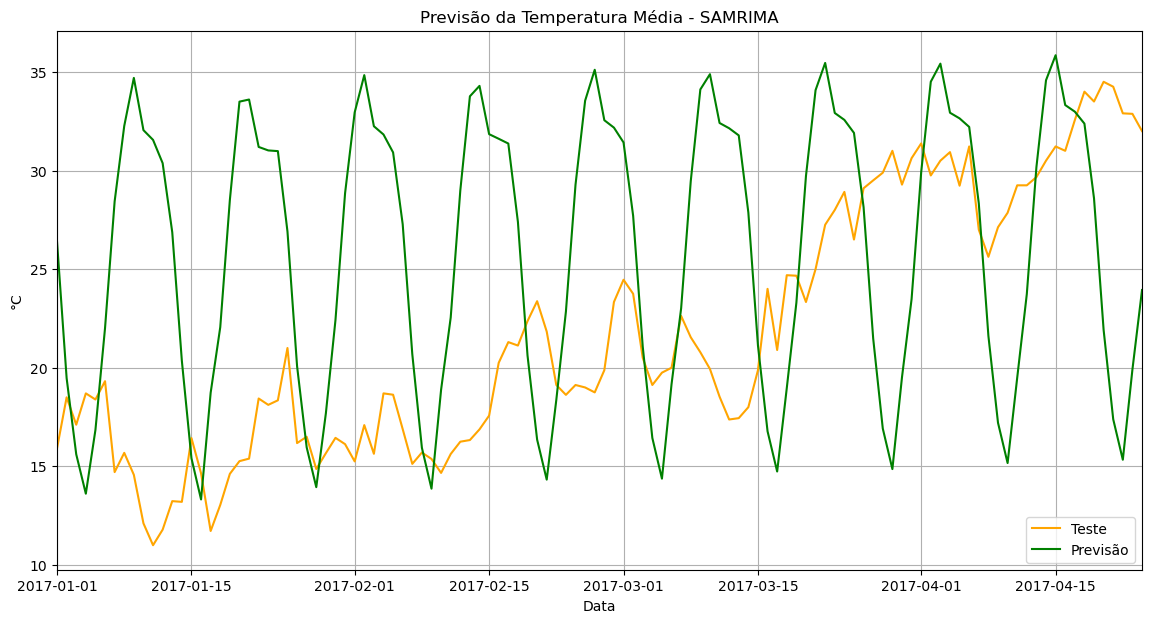

In [78]:
r2 = r2_score(df_teste.temperatura_media, sarima_pred)
mse = mean_squared_error(df_teste.temperatura_media, sarima_pred)
rmse = np.sqrt(mean_squared_error(df_teste.temperatura_media, sarima_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo.aic())

plt.figure(figsize=(14, 7))
plt.plot(df_teste.index, df_teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(df_teste.index, sarima_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMA')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.grid(True)
plt.show()

## 9.2 SARIMAX

In [79]:
n_periodos = len(df_teste)
sarimax_pred  = modelo1.predict(n_periods=n_periodos, X = df_teste[['humidade','velocidade_do_vento','mes','estacao']])

R2 score: 0.6386842887850965
MSE: 14.487200888946221
RMSE: 3.8062055762854192
AIC: 78.025750820094


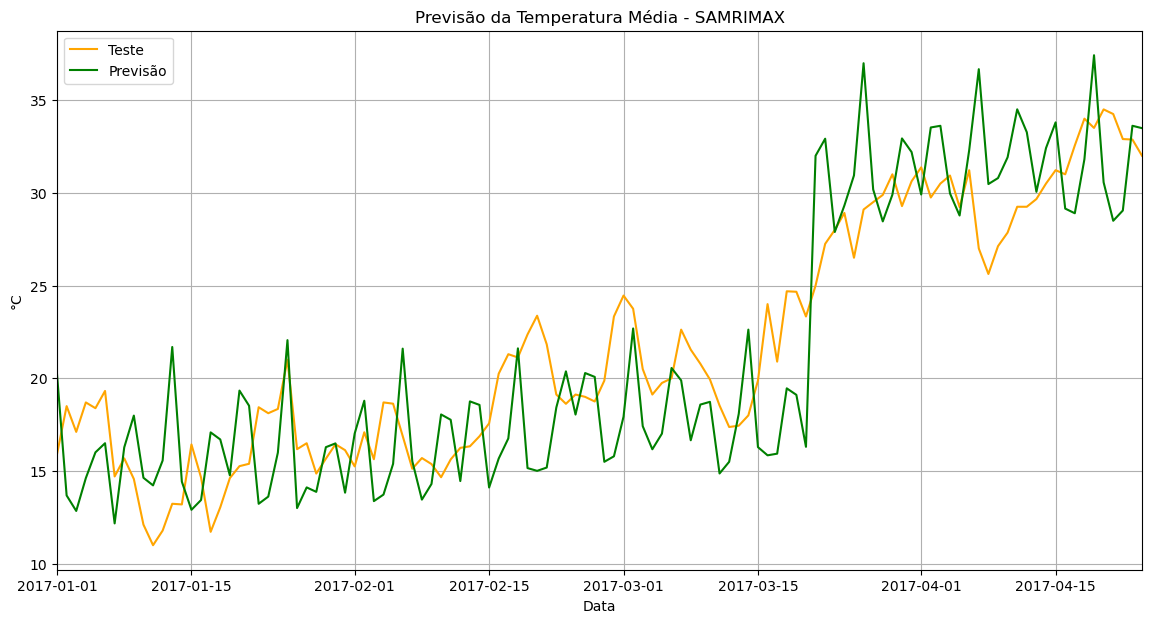

In [80]:
r2 = r2_score(df_teste.temperatura_media, sarimax_pred)
mse = mean_squared_error(df_teste.temperatura_media, sarimax_pred)
rmse = np.sqrt(mean_squared_error(df_teste.temperatura_media, sarimax_pred))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print("AIC:", modelo.aic())

plt.figure(figsize=(14, 7))
plt.plot(df_teste.index, df_teste.temperatura_media, label='Teste', color= 'orange')
plt.plot(df_teste.index, sarimax_pred, label='Previsão', color='green')
plt.legend()
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - SAMRIMAX')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.grid(True)
plt.show()

## 9.3 Prophet1

In [81]:
p_df_teste = df_teste.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [82]:
previsao = modelo_p.predict(p_df_teste[['ds', 'y']])

In [83]:
predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_df_teste['ds']]

R2 score: 0.712239080738027
MSE: 11.537971131447662
RMSE: 3.396758915708865


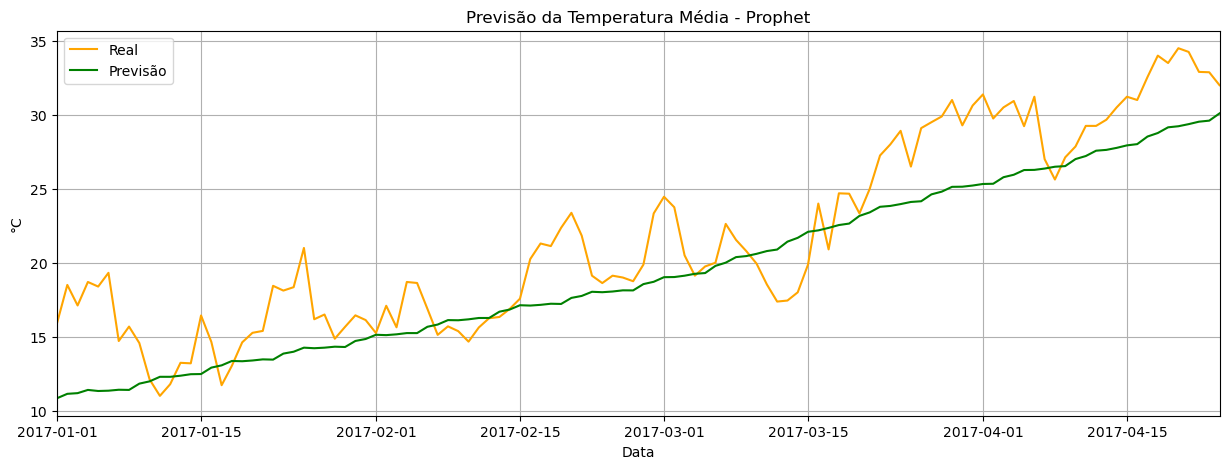

In [84]:
r2 = r2_score(p_df_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_df_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_df_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df_teste['ds'], p_df_teste['y'], color='orange', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.legend()
plt.grid(True)
plt.show()

# 9.4 Prophet2

In [85]:
p_df_teste = df_teste.reset_index().rename(columns={'data': 'ds', 'temperatura_media': 'y'})

In [86]:
previsao = modelo_p2.predict(p_df_teste)

In [87]:
predicao = previsao[['ds', 'yhat']].set_index('ds').loc[p_df_teste['ds']]

R2 score: 0.80310437766056
MSE: 7.894664822059079
RMSE: 2.809744618654706


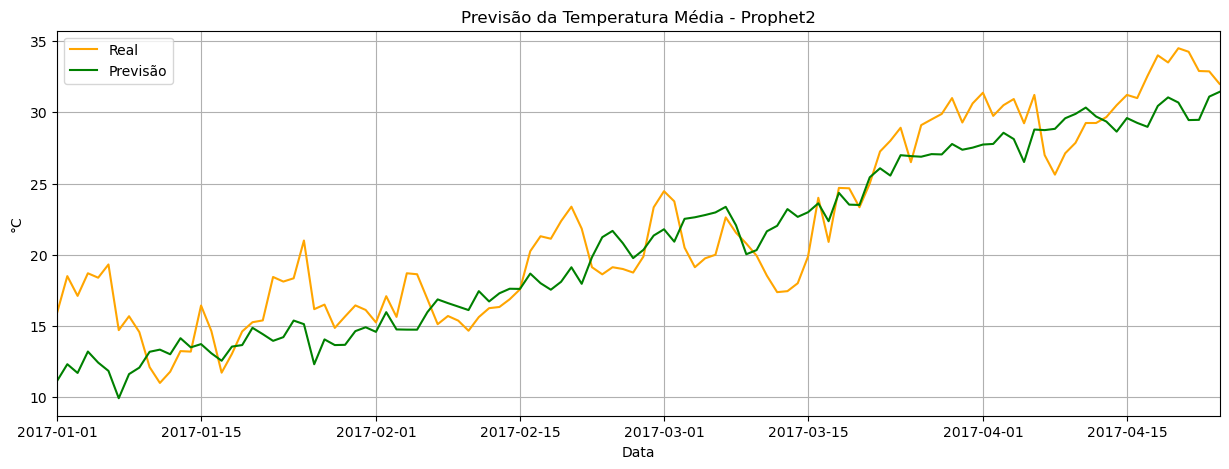

In [88]:
r2 = r2_score(p_df_teste['y'], predicao['yhat'])
mse = mean_squared_error(p_df_teste['y'], predicao['yhat'])
rmse = np.sqrt(mean_squared_error(p_df_teste['y'], predicao['yhat']))

print(f'R2 score: {r2}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

plt.figure(figsize=(15, 5))
plt.plot(p_df_teste['ds'], p_df_teste['y'], color='orange', label='Real')
plt.plot(predicao.index, predicao['yhat'], color='green', label='Previsão')
plt.xlabel('Data')
plt.ylabel('°C')
plt.title('Previsão da Temperatura Média - Prophet2')
plt.xlim(df_teste.index.min(), df_teste.index.max())
plt.legend()
plt.grid(True)
plt.show()

# 10. Conclusão

Durante os testes de previsão, o modelo Prophet demonstrou um desempenho superior comparado aos modelos SARIMA e SARIMAX. As métricas de erro quadrático médio (MSE) de teste para o Prophet foram mais baixas, indicando uma melhor capacidade de generalização e previsão para dados não vistos.

Por outro lado, ao avaliar as métricas de treino, o modelo SARIMAX mostrou-se mais eficiente. As métricas MSE de treino para o SARIMAX foram menores, sugerindo que ele conseguiu capturar bem os padrões presentes nos dados de treino.

No entanto, o modelo SARIMA apresentou sinais claros de overfitting. Embora tenha performado de forma semelhante aos outros modelos durante o treino, com métricas MSE de treino comparáveis, seu desempenho nos testes foi significativamente pior. Isso indica que o SARIMA foi capaz de ajustar-se bem aos dados de treino, mas não conseguiu generalizar adequadamente para novos dados.

Abaixo estão as métricas MSE de treino e teste para cada modelo:

<b> Prophet1: </b>

MSE Treino: 8.9572    
MSE Teste: 11.5380  

<b> Prophet2: </b>

MSE Treino: 6.2856  
MSE Teste: 7.8947  

<b> SARIMA: </b>

MSE Treino: 4.3389  
MSE Teste: 101.7793    

<b> SARIMAX: </b>

MSE Treino: 3.6526  
MSE Teste: 14.4872  

Esses resultados destacam a importância de avaliar tanto as métricas de treino quanto de teste ao escolher um modelo de previsão, e mostram que a capacidade de generalização é crucial para a eficácia em cenários do mundo real.